## Intro

Wordnet is blah blah blah.

### Other resources hooked up to WordNet

Let's use the following environment vars:

```python
CORPUS = /Users/gawron/ext/corpus/
CODE = /Users/gawron/Desktop/src/sentiment_tagger/
```

1.  Sentiwordsnet: /Users/gawron/ext/corpus/sentiwordnet; access_wordnet_for_sentiwordnet.py contains code 
    for linking valence.
2.  FrameNet.  XML format for frames.  Version 1.5.  `CORPUS`/framenet_plus/framenet
    has the Framenet data; `CODE`/mt/framenet has python code for loading and reading the 
    XMl data (using the Python `xml` module).

In [1]:
import nltk
stemmers = [nm for nm in dir(nltk) if "temmer" in nm]
print(stemmers)
stemmer = nltk.PorterStemmer()
#stemmer.stem("sadness")

['ISRIStemmer', 'LancasterStemmer', 'PorterStemmer', 'RSLPStemmer', 'RegexpStemmer', 'SnowballStemmer', 'StemmerI']


In [2]:
from nltk.corpus import wordnet as wn
#from nltk import wordnet as wnl


In [13]:
all_ss = list(wn.all_synsets())

The parts of speech in wordnet: `s` is satellite (to be explained).

In [30]:
from collections import Counter

ctr = Counter(ss.pos() for ss in all_ss)
ctr

Counter({'n': 82115, 'v': 13767, 's': 10693, 'a': 7463, 'r': 3621})

What satellites all share, a synset they are all satellites of some **head**, linked via the `similar_to` relation:

In [112]:
all_satellites = sorted(ss.name() for ss in all_ss if ss.pos() == "s")
print(len(all_satellites))
Counter(len(wn.synset(ss).similar_tos()) for ss in all_satellites)

10693


Counter({1: 10693})

For example, Consider the senses of "bald", all of which have pos "s".

In [53]:
baldies = wn.synsets("bald","a")
for ss in baldies:
    print(ss.name(),ss.definition())

bald.s.01 with no effort to conceal
bald.s.02 lacking hair on all or most of the scalp
bald.s.03 without the natural or usual covering


In [202]:
def print_head_and_satellites(head,satellites):
    banner = f"Head: {head.name()}"
    print(banner)
    print("="*len(banner))
    for sat in satellites:
        print(f"  {sat.name()}")
    
def get_wheel (ss,verbose=False):
    """
    ss is a satellite if some head (because it is pos s).
    
    Return the head and all satellites of the ehad (including ss)
    """
    assert ss.pos() == "s", "Only synsets with part of speech s have wheels"
    # The rule is that satellites have only one head linked by .similar_tos()
    head = ss.similar_tos()[0]
    satellites = get_satellites(head,verbose=verbose)
    return head,satellites

def get_satellites(head,verbose=False,include_head=False):
    """
    Return all satellites of {head} 
    """
    satellites = head.similar_tos()
    if verbose:
        print_head_and_satellites(head,satellites)
    return [head] + satellites

def get_wheels_and_axle(ss,verbose=False,return_set=False):
    head, satellites = get_wheel (ss,verbose=verbose)
    # antonymy is an attribute of lemmas, not synsets.  This is confusing.
    antonyms = [ant.synset() for lem in head.lemmas() for ant in lem.antonyms()]
    if verbose:
        print()
    ant_wheels = [get_satellites (ant,verbose=verbose,include_head=True) for ant in antonyms] 
    if return_set:
        res = set([head]).union(satellites)
        for wheel in ant_wheels:
            res.update(wheel)
        return res
    else:
        return head, satellites, ant_wheels

Let's look at the head of the first sense the synset `bald.s.01`, and get all the `similar_tos()` of that head (all of that head's satellites).

The head connected to `bald.s.01` by `similar_tos()` is `overt.a.01`.  The 4 satellites of `overt.a.01`
are the `similar_tos()` of `overt.a.01`:

In [199]:
ss = baldies[0]
print(ss.name(),end="\n\n")
head, sats = get_wheel(ss,verbose=True)

bald.s.01

Head: overt.a.01
  naked.s.04
  undisguised.s.01
  bald.s.01
  visible.s.02


We call little subnetwork a **wheel**: `overt.a.01` is the hub.

This time we find the head and it satellites; then we find the sole antonym of the head `overt.a.01`, `covert.a.01`, which is another head, and find all of its satellites:

In [206]:
res = get_wheels_and_axle(ss,return_set=True)
#wn.synset("overt.a.01") in res
res

{Synset('backstair.s.01'),
 Synset('bald.s.01'),
 Synset('black.s.10'),
 Synset('clandestine.s.01'),
 Synset('cloaked.s.01'),
 Synset('collusive.s.01'),
 Synset('covert.a.01'),
 Synset('naked.s.04'),
 Synset('overt.a.01'),
 Synset('secret.s.04'),
 Synset('secret.s.09'),
 Synset('sub-rosa.s.01'),
 Synset('subterranean.s.02'),
 Synset('under_wraps.s.01'),
 Synset('undisclosed.s.01'),
 Synset('undisguised.s.01'),
 Synset('visible.s.02')}

In [200]:
head, satellites, ant_wheels = get_wheels_and_axle(ss,verbose=True)

Head: overt.a.01
  naked.s.04
  undisguised.s.01
  bald.s.01
  visible.s.02

Head: covert.a.01
  secret.s.09
  clandestine.s.01
  backstair.s.01
  cloaked.s.01
  sub-rosa.s.01
  under_wraps.s.01
  collusive.s.01
  undisclosed.s.01
  subterranean.s.02
  black.s.10
  secret.s.04


Finding antonyms

In [98]:
wn.synsets("happy","a")[0].lemmas()[0].antonyms()

[Lemma('unhappy.a.01.unhappy')]

In [111]:
len(satellites)

4

In [115]:
import random
sat_samp = random.sample(all_satellites,60)
for sat in sat_samp:
    print(sat)
    get_wheels_and_axle(wn.synset(sat),verbose=True)
    print(end="\n^^^^^^^^^^^^^^^^^^^^^^\n")

supperless.s.01
Head: hungry.a.01
  supperless.s.01
  peckish.s.01
  empty.s.03
  famished.s.01

Head: thirsty.a.02

^^^^^^^^^^^^^^^^^^^^^^
deprecative.s.02
Head: critical.a.01
  captious.s.01
  censorious.s.01
  hypercritical.s.01
  scathing.s.01
  deprecative.s.02
  searing.s.01

Head: uncritical.a.02

^^^^^^^^^^^^^^^^^^^^^^
apostate.s.01
Head: unfaithful.a.01
  punic.s.02
  apostate.s.01
  untrue.s.02

Head: faithful.a.01
  true.s.03
  firm.s.10

^^^^^^^^^^^^^^^^^^^^^^
oblanceolate.s.01
Head: simple.a.06
  apiculate.s.01
  lanceolate.s.01
  lyrate.s.01
  oblanceolate.s.01
  ovate.s.01
  two-needled.s.01
  acerate.s.01
  peltate.s.01
  cuneate.s.01
  spatulate.s.01
  acuminate.s.01
  pandurate.s.01
  dolabriform.s.01
  reniform.s.01
  oblong.s.01
  obtuse.s.02
  orbiculate.s.01
  obovate.s.01
  caudate.s.02
  three-needled.s.01
  needled.s.01
  ensiform.s.01
  five-needled.s.01
  elliptic.s.01
  perfoliate.s.01
  unlobed.s.01
  deltoid.s.01
  sagittate.s.01
  four-needled.s.01
  hast

## Adjectives

Strategy find emotion nouns using hypernym relations.  Use stemmer to find related adjectives

In [3]:

stemmer.stem("sadness")

'sad'

In [4]:
def get_definitions (ss_set,verbose = False):
    defs = [(ss.name(),ss.definition()) for ss in ss_set]
    if verbose:
        for (nm,df) in defs:
            print(f"{nm:>20}     {df}")
    return defs

In [5]:
sad_synsets = [ss for ss in wn.synsets('sad')]
sad_synsets

[Synset('sad.a.01'), Synset('sad.s.02'), Synset('deplorable.s.01')]

In [6]:
defs = get_definitions(sad_synsets,verbose=True)

            sad.a.01     experiencing or showing sorrow or unhappiness; ; - Christina Rossetti
            sad.s.02     of things that make you feel sad; ; ; ; - Christina Rossetti
     deplorable.s.01     bad; unfortunate


Within the adjectives the hypernym structure has not been done.

There's a semantic reason that has to do with a basic assumption/limitation of wn.  There are no
abstract nodes.  And since there is no adjective meaning "having an emotion" no adjective
can have a synset corresponding to the sense "having an emotion" as a synset.

In [7]:
sad_synset_0 = sad_synsets[0]
sad_synset_0.hypernyms()

[]

###  Bingo!  Got one!

Here's one intensity pair found.

In [8]:
anger_synsets = [ss for ss in wn.synsets('anger')]
anger_synsets

[Synset('anger.n.01'),
 Synset('anger.n.02'),
 Synset('wrath.n.02'),
 Synset('anger.v.01'),
 Synset('anger.v.02')]

So these are the ones we ignore.  The basic level emotion words.

In [48]:
anger_hypernyms = anger_synsets[0].hypernyms()
emotion_ss = anger_hypernyms[0]
emotion_ss

Synset('emotion.n.01')

All the senses:

In [49]:
rage_synsets = [ss for ss in wn.synsets('rage','n')]
rage_synsets

[Synset('fury.n.01'),
 Synset('rage.n.02'),
 Synset('rage.n.03'),
 Synset('rage.n.04'),
 Synset('fad.n.01')]

Bingo:

In [50]:
{hn for ss in rage_synsets for hn in ss.hypernyms()}

{Synset('anger.n.01'),
 Synset('anger.n.02'),
 Synset('desire.n.03'),
 Synset('fashion.n.03'),
 Synset('violence.n.03')}

In [1092]:
get_defs(emotion_ss.hyponyms())

emotional_state.n.01 the state of a person's emotions (especially with regard to pleasure or dejection)
hate.n.01         the emotion of intense dislike; a feeling of dislike so strong that it demands action
fear.n.03         a feeling of profound respect for someone or something
joy.n.01          the emotion of great happiness
love.n.01         a strong positive emotion of regard and affection
anxiety.n.02      a vague unpleasant emotion that is experienced in anticipation of some (usually ill-defined) misfortune
conditioned_emotional_response.n.01 an emotional response that has been acquired by conditioning
anger.n.01        a strong emotion; a feeling that is oriented toward some real or supposed grievance
fear.n.01         an emotion experienced in anticipation of some specific pain or danger (usually accompanied by a desire to flee or fight)


## Get emotion noun synsets

In [117]:
#  find all the emotion bnoun synsets in the obvious way
anger_synsets = [ss for ss in wn.synsets('anger')]
anger_hypernyms = anger_synsets[0].hypernyms()
emotion_ss = anger_hypernyms[0]

def get_hypos (ss_set):
    return {hn for ss in ss_set for hn in ss.hyponyms()}

def get_hypos_iter (root):
    global accumulated
    hl0 = root.hyponyms()
    accumulated = set(hl0)
    current = hl0
    while current:
        current = get_hypos(current)
        accumulated.update(current)
    return accumulated

def get_lemmas_iter(root):
    return {l for ss in get_hypos_iter(root) for l in ss.lemmas()}.union(root.lemmas())

def get_emotion_nouns(root = emotion_ss,hn_list=None):
    return get_hypos_iter (root)

def get_defs (ss_seq):
    for ss in ss_seq:
        print(f"{ss.name():<17} {ss.definition()}")

emotion_nouns = get_emotion_nouns()
len(emotion_nouns)

129

The synset one up in the hierarchy (hypernym of "emotion.n.01") is actually what we
want.  It's "feeling.n.01".

## Cognition

Basically everything under cognition is a complete mess. Better to find another way to
mine this portion of lexicon.  Wordnet just throws in so much noise that a vast amount
of human intervention would be needed to find the target words.

In [998]:
for ss in wn.synset("cognition.n.01").hyponyms():
    print(ss,len(get_emotion_nouns(root = ss)))

Synset('perception.n.04') 3
Synset('place.n.03') 1
Synset('vocabulary.n.02') 0
Synset('structure.n.03') 75
Synset('lexis.n.01') 0
Synset('information.n.02') 639
Synset('episteme.n.01') 0
Synset('mind.n.01') 5
Synset('cognitive_factor.n.01') 47
Synset('process.n.02') 573
Synset('history.n.05') 0
Synset('inability.n.01') 33
Synset('equivalent.n.01') 8
Synset('process.n.04') 18
Synset('content.n.05') 1943
Synset('public_knowledge.n.01') 4
Synset('practice.n.05') 13
Synset('attitude.n.01') 161
Synset('ability.n.02') 370


In [118]:
feeling_nouns = get_emotion_nouns(root = wn.synset("feeling.n.01"))

In [119]:
feeling_nouns2 = get_lemmas_iter(root = wn.synset("feeling.n.01"))

In [120]:
len(feeling_nouns2)

805

In [1129]:
wordset = {l.name() for l in feeling_nouns2}
len(wordset)

805

In [121]:
len(feeling_nouns)

445

In [1072]:
# 3 weird nouns
#perception_nouns = get_emotion_nouns(root = wn.synset("perception.n.04"))
# 161 words, most;y isms (e.g., agnosticism) some concept/attitude words irreverence, islamophobia, neoteny
ism_nouns = get_hypos_iter(root = wn.synset("attitude.n.01"))
# 5 weird nouns
#mind_nouns =  get_emotion_nouns(root = wn.synset('mind.n.01'))

In [1137]:
# Almost all medical words but occasionally not (sunset, variance, nuisance, noon,midnight)
information_nouns = get_hypos_iter(root = wn.synset("information.n.02"))

In [1073]:
len(process_nouns),len(information_nouns),len(mind_nouns),len(ism_nouns)

(573, 639, 5, 161)

In [1074]:
#discipline names, some isms,
content_nouns = get_hypos_iter(root = wn.synset("content.n.05"))

In [1075]:
cognitive_factor_nouns = get_hypos_iter(root = wn.synset("cognitive_factor.n.01"))

In [1087]:
## This is a terrible name for this lexical set  which includes idyll, harmonic_motion, aircraft_landing,  
## and channel.n
psychological_feature_nouns = list(get_hypos_iter(root = wn.synset('psychological_feature.n.01')))

In [1091]:


get_defs (psychological_feature_nouns[340:390])

orthoepy.n.02     a term formerly used for the part of phonology that dealt with the `correct' pronunciation of words and its relation to `correct' orthography
abscess.n.01      symptom consisting of a localized collection of pus surrounded by inflamed tissue
contempt_of_court.n.01 disrespect for the rules of a court of law
apnea.n.01        transient cessation of respiration
channel.n.05      (often plural) a means of communication or access
superiority.n.03  displaying a sense of being better than others
harmonic_motion.n.01 a periodic motion in which the displacement is either symmetrical about a point or is the sum of such motions
tetralogy.n.01    a series of four related works (plays or operas or novels)
scalage.n.01      estimation of the amount of lumber in a log
stare.n.01        a fixed look with eyes open wide
gripe.n.01        informal terms for objecting
copying.n.01      an act of copying
hydropathy.n.01   the internal and external use of water in the treatment of disease

In [1082]:
for ss in cognitive_factor_nouns:
    print(f"{ss.name():<17}   {ss.definition()}")

temptation.n.01     something that seduces or has the quality to seduce
clincher.n.02       a point or fact or remark that settles something conclusively
straitjacket.n.01   anything immaterial that severely hinders or confines
trouble.n.01        a source of difficulty
lifeline.n.02       support that enables people to survive or to continue doing something (often by providing an essential connection)
forbidden_fruit.n.01   originally an apple from the tree of knowledge of good and evil in the Garden of Eden; it is now used to refer to anything that is tempting but dangerous (as sexuality)
influence.n.03      a cognitive factor that tends to have an effect on what you do
barrier.n.02        any condition that makes it difficult to make progress or to achieve an objective
imponderable.n.01   a factor whose effects cannot be accurately assessed
bait.n.01           anything that serves as an enticement
difficulty.n.02     a factor causing trouble in achieving a positive result or tending

In [1068]:
powerlessness_ss = wn.synset("drag.n.03").hypernyms()[0].hypernyms()[0].hypernyms()[0].hypernyms()[0]
powerlessness_nouns = get_emotion_nouns(root = powerlessness_ss)
powerlessness_nouns

{Synset('boringness.n.01'),
 Synset('drag.n.03'),
 Synset('dullness.n.02'),
 Synset('helplessness.n.01'),
 Synset('ineffectiveness.n.01'),
 Synset('inefficacy.n.01'),
 Synset('jejunity.n.01'),
 Synset('paper_tiger.n.01'),
 Synset('ponderousness.n.01'),
 Synset('tediousness.n.01'),
 Synset('uninterestingness.n.01'),
 Synset('unpersuasiveness.n.01'),
 Synset('voicelessness.n.03')}

In [1061]:
for ss in wn.synsets("drag","n"):
    print(ss, ss.definition())

Synset('drag.n.01') the phenomenon of resistance to motion through a fluid
Synset('drag.n.02') something that slows or delays progress
Synset('drag.n.03') something tedious and boring
Synset('drag.n.04') clothing that is conventionally worn by the opposite sex (especially women's clothing when worn by a man)
Synset('puff.n.07') a slow inhalation (as of tobacco smoke)
Synset('drag.n.06') the act of dragging (pulling with force)


In [979]:
for ss in wn.synsets("anticipation","n"):
    print(ss, get_hypers_iter (ss))
    print()

Synset('anticipation.n.01') {Synset('feeling.n.01'), Synset('expectation.n.03'), Synset('attribute.n.02'), Synset('state.n.02'), Synset('abstraction.n.06'), Synset('entity.n.01')}

Synset('anticipation.n.02') {Synset('psychological_feature.n.01'), Synset('expectation.n.01'), Synset('cognition.n.01'), Synset('abstraction.n.06'), Synset('entity.n.01'), Synset('content.n.05'), Synset('belief.n.01')}

Synset('prediction.n.01') {Synset('higher_cognitive_process.n.01'), Synset('psychological_feature.n.01'), Synset('entity.n.01'), Synset('reasoning.n.01'), Synset('abstraction.n.06'), Synset('cognition.n.01'), Synset('process.n.02'), Synset('thinking.n.01')}

Synset('anticipation.n.04') {Synset('attribute.n.02'), Synset('state.n.02'), Synset('abstraction.n.06'), Synset('entity.n.01'), Synset('condition.n.01'), Synset('hopefulness.n.01')}



In [1099]:
wn.synset('anticipation.n.02').lemma_names()

['anticipation', 'expectancy']

In [1096]:
# These are almost all mnames for religious doctrines but just to be confusing anticipation.n.02 is in there
# as is conviction, decuisuion
belief_nouns = sorted(ss.name() for ss in list(get_hypos_iter(root = wn.synset('belief.n.01'))))

In [1100]:
belief_nouns2 = list(get_hypos_iter(root = wn.synset('belief.n.02')))

A little known fact about the `wn.synset()` function: the key `"belief.n.02"` retrieves the second synset
associated with the noun *belief*, whether or not  the official name of that synset is `"belief.n.02"`.
In fact, the "official" name for the second sense of "belief" is "impression.n.01",

In [1122]:
wn.synset('belief.n.02').name()

'impression.n.01'

The objects returned for both keys are the same:

In [1120]:
wn.synset('belief.n.02') == wn.synset('impression.n.01')

True

Moreover the associated lemmas are the same:

In [1119]:
wn.lemma('belief.n.02.belief') == wn.lemma('impression.n.01.belief')

True

It is an error however to ask for the nth synset when the number of senses for the
for the form,pos pair is fewer than n.  Since `belief.n` has only two definitions, 
the following raises both a 

```python
WordNetError: Lemma 'belief' with part of speech 'n' only has 2 senses
```

and an `IndexError`.




In [1123]:
wn.synset('belief.n.03')

WordNetError: Lemma 'belief' with part of speech 'n' only has 2 senses

In [1114]:
get_lemmas_iter(wn.synset('belief.n.02'))

{Lemma('impression.n.01.belief'),
 Lemma('heart.n.01.bosom'),
 Lemma('effect.n.03.effect'),
 Lemma('impression.n.01.feeling'),
 Lemma('first_blush.n.01.first_blush'),
 Lemma('heart.n.01.heart'),
 Lemma('intuition.n.02.hunch'),
 Lemma('impression.n.01.impression'),
 Lemma('intuition.n.02.intuition'),
 Lemma('impression.n.01.notion'),
 Lemma('impression.n.01.opinion'),
 Lemma('presence.n.04.presence'),
 Lemma('sound_effect.n.01.sound_effect'),
 Lemma('special_effect.n.01.special_effect'),
 Lemma('stage_effect.n.01.stage_effect'),
 Lemma('intuition.n.02.suspicion')}

In [1106]:
wn.synset('belief.n.02').lemmas()

[Lemma('impression.n.01.impression'),
 Lemma('impression.n.01.feeling'),
 Lemma('impression.n.01.belief'),
 Lemma('impression.n.01.notion'),
 Lemma('impression.n.01.opinion')]

In [1102]:
get_defs(wn.synsets("belief","n"))

belief.n.01       any cognitive content held as true
impression.n.01   a vague idea in which some confidence is placed


In [1101]:
belief_nouns2

[Synset('stage_effect.n.01'),
 Synset('presence.n.04'),
 Synset('special_effect.n.01'),
 Synset('sound_effect.n.01'),
 Synset('intuition.n.02'),
 Synset('first_blush.n.01'),
 Synset('effect.n.03'),
 Synset('heart.n.01')]

In [1097]:
belief_nouns

['abolitionism.n.01',
 'absolutism.n.04',
 'aditya.n.01',
 'adonis.n.03',
 'adventism.n.01',
 'aesir.n.01',
 'aesthetic.n.01',
 'aether.n.01',
 'aglaia.n.01',
 'ahimsa.n.01',
 'ahura.n.01',
 'albigensianism.n.01',
 'amateurism.n.01',
 'amen.n.01',
 'amoralism.n.01',
 'anabaptism.n.01',
 'andvari.n.01',
 'angel.n.01',
 'anglicanism.n.01',
 'anglo-catholicism.n.01',
 'anglo-saxon_deity.n.01',
 'animalism.n.01',
 'animism.n.01',
 'anticipation.n.02',
 'antiestablishmentarianism.n.01',
 'antinomianism.n.01',
 'anunnaki.n.01',
 'apophatism.n.01',
 'apparition.n.01',
 'apprehension.n.03',
 'archangel.n.01',
 'arianism.n.01',
 'aristotelianism.n.01',
 'arminianism.n.01',
 'article_of_faith.n.01',
 'asceticism.n.01',
 'asvins.n.01',
 'athanasian_creed.n.01',
 'athanasianism.n.01',
 'autotelism.n.01',
 'avatar.n.02',
 'bad_fairy.n.01',
 'bahaism.n.01',
 'banshee.n.01',
 'baptistic_doctrine.n.01',
 'boehmenism.n.01',
 'bogey.n.01',
 'brahmanism.n.02',
 'british_empiricism.n.01',
 'buddhism.n.02'

In [56]:
feeling_nouns

{Synset('abashment.n.01'),
 Synset('abhorrence.n.01'),
 Synset('acquired_taste.n.01'),
 Synset('addiction.n.02'),
 Synset('admiration.n.01'),
 Synset('affect.n.01'),
 Synset('affection.n.01'),
 Synset('afterglow.n.02'),
 Synset('agape.n.01'),
 Synset('agape.n.02'),
 Synset('aggravation.n.01'),
 Synset('aggression.n.02'),
 Synset('agitation.n.03'),
 Synset('agony.n.01'),
 Synset('alarm.n.01'),
 Synset('algolagnia.n.01'),
 Synset('alienation.n.01'),
 Synset('ambition.n.01'),
 Synset('ambivalence.n.01'),
 Synset('american_dream.n.01'),
 Synset('amicability.n.01'),
 Synset('amorousness.n.01'),
 Synset('amorousness.n.02'),
 Synset('amour_propre.n.01'),
 Synset('amusement.n.01'),
 Synset('anaphrodisia.n.01'),
 Synset('anger.n.01'),
 Synset('anglophilia.n.01'),
 Synset('anglophobia.n.01'),
 Synset('angst.n.01'),
 Synset('anguish.n.01'),
 Synset('animosity.n.01'),
 Synset('annoyance.n.02'),
 Synset('antagonism.n.03'),
 Synset('anticipation.n.01'),
 Synset('antipathy.n.01'),
 Synset('anxiety.n.

## searching for intensity pairs

In [123]:
from collections import defaultdict

def get_hypers (ss_set):
    return {hn for ss in ss_set for hn in ss.hypernyms()}

def get_hypers_iter (root):
    global accumulated
    hl0 = root.hypernyms()
    accumulated = set(hl0)
    current = hl0
    while current:
        current = get_hypers(current)
        accumulated.update(current)
    return accumulated

def ss_set_to_word_set (ss_set):
    return sorted(list(set([nm for ss in ss_set for nm in ss.lemma_names()])))

def expand_intensity_pairs (ips):
    """
    ips is a dict of teh form ss => ss_list
    find all the words related to ss_w and all the words ss_rel_w related the ss_list members
    construnct a word to word_liust dict
    """
    new_dict = defaultdict(list)
    for ss,ss_list in ips.items():
        for ss_w in ss.lemma_names():
            for ss_rel_w in ss_set_to_word_set (ss_list):
                new_dict[ss_w].append(ss_rel_w)
    return new_dict

def output_intensity_word_dict_to_file(intensity_word_dict,fn):
    keywords = sorted(list(intensity_word_dict.keys()))
    with open(fn,"w") as ofh:
        for k in keywords:
            word_list = " ".join(sorted(intensity_word_dict[k]))
            print(f"{k:<30}\t{word_list}",file=ofh)
            
def output_intensity_pairs_to_file(intensity_pairs,fn):
    keywords = sorted(list(intensity_pairs.keys()))
    get_name = lambda x:getattr(x,"name")()
    with open(fn,"w") as ofh:
        for k in keywords:
            word_list = " ".join(sorted(map(get_name,intensity_pairs[k])))
            print(f"{k.name():<30}\t{word_list}",file=ofh)

In [124]:
pair_dict = dict()
feeling_root = wn.synset("feeling.n.01")
intensity_pairs = {n_ss:[ss for ss in n_ss.hypernyms() if feeling_root in get_hypers_iter(ss)] 
                         for n_ss in feeling_nouns} 
intensity_word_dict =  expand_intensity_pairs (intensity_pairs)
output_intensity_word_dict_to_file(intensity_word_dict,"intensity_pairs.txt")
intensity_word_dict

defaultdict(list,
            {'ardor': ['passion',
              'passionateness',
              'avidity',
              'avidness',
              'eagerness',
              'keenness',
              'love'],
             'ardour': ['passion',
              'passionateness',
              'avidity',
              'avidness',
              'eagerness',
              'keenness',
              'love'],
             'fervor': ['passion', 'passionateness'],
             'fervour': ['passion', 'passionateness'],
             'fervency': ['passion', 'passionateness'],
             'fire': ['passion', 'passionateness'],
             'fervidness': ['passion', 'passionateness'],
             'worry': ['anxiety'],
             'trouble': ['anxiety'],
             'shamefacedness': ['embarrassment'],
             'sheepishness': ['embarrassment'],
             'heaviness': ['sadness', 'unhappiness'],
             'gaiety': ['happiness', 'levity'],
             'merriment': ['happiness'],
       

In [73]:
wn.synsets("furious")

[Synset('ferocious.s.01'), Synset('angered.s.01'), Synset('angry.s.02')]

In [74]:
wn.synsets("angry")

[Synset('angry.a.01'), Synset('angry.s.02'), Synset('angry.s.03')]

In [71]:
output_intensity_pairs_to_file(intensity_pairs,"intensity_synsets.txt")

In [28]:
def get_h (wd,pos="n"):
    return [h for ss in wn.synsets(wd, pos) for h in ss.hypernyms()]

print("odium n = ss_s =>")
L = get_h("odium","n")
print(L)
M = [h for ss in L for h in ss.hypernyms()]
print(M)
N = [h for ss in M for h in ss.hypernyms()]
print(N)

odium n = ss_s =>
[Synset('shame.n.02'), Synset('hate.n.01'), Synset('disgust.n.01')]
[Synset('dishonor.n.01'), Synset('emotion.n.01'), Synset('dislike.n.02')]
[Synset('standing.n.01'), Synset('feeling.n.01'), Synset('feeling.n.01')]


In [42]:
get_name = lambda x:getattr(x,"name")()
sorted(map(get_name,L))

['disgust.n.01', 'hate.n.01', 'shame.n.02']

In [12]:
ambition_ss_s = wn.synsets("ambition","n")
get_definitions(ambition_ss_s)

[('ambition.n.01', 'a cherished desire'),
 ('ambition.n.02', 'a strong drive for success')]

In Wordnet *ambition* is not an emotion.  It's a feeling.

```
ambition -> desire -> feeling
```

The disctinction between feeling and emotion is made, for example. in the field of clinical counseling.  The [Wake Forest Page Counseling Blog Page on feelings and emotions](https://counseling.online.wfu.edu/blog/difference-feelings-emotions/#:~:text=A%20fundamental%20difference%20between%20feelings,the%20depths%20of%20their%20emotions.) says:

>Many people use the terms “feeling” and “emotion” as synonyms, but they are not interchangeable. While they have similar elements, there is a marked difference between feelings and emotions.

>**Feelings**. Both emotional experiences and physical sensations — such as hunger or pain — bring about feelings, according to Psychology Today. Feelings are a conscious experience, although not every conscious experience, such as seeing or believing, is a feeling, as explained in the article.

>**Emotions**. According to Psychology Today, an emotion “can only ever be felt…through the emotional experiences it gives rise to, even though it might be discovered through its associated thoughts, beliefs, desires, and actions.” Emotions are not conscious but instead manifest in the unconscious mind. These emotions can be brought to the surface of the conscious state through extended psychotherapy.

>A fundamental difference between feelings and emotions is that feelings are experienced consciously, while emotions manifest either consciously or subconsciously. Some people may spend years, or even a lifetime, not understanding the depths of their emotions.



In [16]:
ambition_ss.hypernyms()[0].hypernyms()

[Synset('feeling.n.01')]

In [ ]:
intensity_words

## hierarchy exploration

In [125]:
def get_hypos (ss_set):
    return {hn for ss in ss_set for hn in ss.hyponyms()}



def get_hypers_list (ss_set):
    return [hn for ss in ss_set for hn in ss.hypernyms()]

def get_hypers_iter_list (root):
    global accumulated
    hl0 = root.hypernyms()
    accumulated = hl0
    current = hl0
    while current:
        current = get_hypers_list(current)
        accumulated.extend(current)
    return accumulated

def get_hypers (ss_set):
    return {hn for ss in ss_set for hn in ss.hypernyms()}

def get_hypers_iter (root):
    global accumulated
    hl0 = root.hypernyms()
    accumulated = set(hl0)
    current = hl0
    while current:
        current = get_hypers(current)
        accumulated.update(current)
    return accumulated

def get_hypos_iter (root):
    global accumulated2
    hl0 = root.hyponyms()
    accumulated2 = set(hl0)
    current = hl0
    while current:
        current = get_hypos(current)
        accumulated2.update(current)
    return accumulated2

def get_hypos_gen (root):
    hl0 = root.hyponyms()
    accumulated2 = set(hl0)
    current = hl0
    while current:
        current = get_hypos(current)
        for hn in current:
            yield current

In [116]:
#all_ss = wn.all_eng_synsets()

Let's find out how deep "emotion.n.01" is and what its hhypernyms are.

Finding the root of the wn hoierarchy:

In [64]:
thing_list = [ss for ss in all_ss if "thing.n.01" == ss.name()]
thing_list

[Synset('thing.n.01')]

In [75]:
search_root = thing_list[0]
search_res = get_hypers_iter (search_root)
search_res

{Synset('abstraction.n.06'),
 Synset('attribute.n.02'),
 Synset('entity.n.01'),
 Synset('situation.n.01'),
 Synset('state.n.02')}

Unnecessary but perhaps a useful code model.

In [160]:
#root = wn.synset("entity.n.01")
##print(root.name())
#ctr = 0
#accum = [(ctr,root)]
#accum0 = [root]
#for ss_set in get_hypos_gen (root):
#    for ss in ss_set:
#        if ss not in accum0:
#            accum.append((ctr,ss))
#            accum0.append(ss)
#    ctr += 1
#    if ctr > 500:
#        break
#print(len(accum),len(accum0), ctr)

2261 2261 501


Here are the hypernyms:

In [177]:
L = list(get_hypers_iter(emotion_ss))
# not in any use ful order
L

[Synset('entity.n.01'),
 Synset('state.n.02'),
 Synset('abstraction.n.06'),
 Synset('feeling.n.01'),
 Synset('attribute.n.02')]

The tree order from the root down

In [ ]:
#  0           1              2          3         4          5
#entity -> abstraction -> attribute -> state -> feeling -> emotion

In [216]:
# depth = 5
get_hypers(get_hypers(get_hypers(get_hypers(get_hypers ({emotion_ss})))))

{Synset('entity.n.01')}

In [126]:
from nltk import Tree

def extend_tree(t,start=0,max_dtrs=5,pass_max_dtrs=False):
    """
    Extends tree from frontier down
    Supports the convention that nltk node labels
    wll be names of synset instances (strings) rather than synset
    instances.
    
    Note that the recursive call to extend_tree does
    not by default pass max_dtrs values.  This is because
    in most cases the deeper parts of teh Wordnet tree
    do not have large numbers of daughters.  When
    inspecting the exceptions, the relevant mother
    node can be navigated to directly.
    """
    for (i,t0) in enumerate(t):
        if isinstance(t0,Tree):
            if pass_max_dtrs:
                extend_tree(t0,max_dtrs=max_dtrs)
            else:
                extend_tree(t0)
        else:
            t[i] = Tree(t0,convert_dtrs(wn.synset(t0).hyponyms()[start:start+max_dtrs]))

def convert_dtrs (dtrs):
    """
    ss_list to string_ist
    """
    return [n.name() for n in dtrs]


def make_trees(root_name,last=0,inc=5):
    """
    Return a list of non overlapping subtrees of the 
    tree rooted at rootname, each tree containing a subsequence 
    of inc of the dtrs of root_name.
    So if inc=5 the first subtree contains the first
    5 daughters, the next the next 5, and so on.
    """
    dtrs = wn.synset(root_name).hyponyms()
    trees = []
    for n in range(last, len(dtrs), inc):
        these_dtrs = dtrs[last:last+inc]
        trees.append(Tree(root_name,convert_dtrs(these_dtrs)))
        last += inc
    return trees

def make_tree(root_name):
    """
    Complete Wordnet tree starting at root_name.
    
    Note: the leaves will be trees with empty dtr lists.
    """
    #last,inc = 0,5
    dtrs_list = []
    tree = Tree(root_name, dtrs_list)
    dtrs = wn.synset(root_name).hyponyms()
    for n in range(len(dtrs)):
        this_dtr = dtrs[n].name()
        tree.append(make_tree(this_dtr))
    return tree

def sub_tree(tree0,start=0,end=None):
    """
    Just a convenience function for displaying
    part of tree0: show only the subtrees for
    dtrs at indices start up to end.
    
    Used for slicing & displaying 
    trees with many dtrs (e.g., "feeling.n.01").
    
    Note that tree[start:end] returns a list of
    trees, which then don't display nicely.
    This is a bandaid for that problem.
    """
    return Tree(tree0.label(), tree0[start:end])

In [219]:
big_tree = make_tree("feeling.n.01")

In [263]:
big_tree[4,2][2:4]

[Tree('confusion.n.03', []), Tree('discomfiture.n.01', [])]

In [281]:
big_tree[3][2:4]

[Tree('ardor.n.03', [Tree('zeal.n.02', [])]), Tree('wildness.n.01', [])]

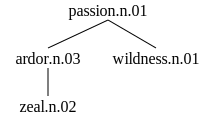

In [282]:
sub_tree(big_tree[3],2,4)

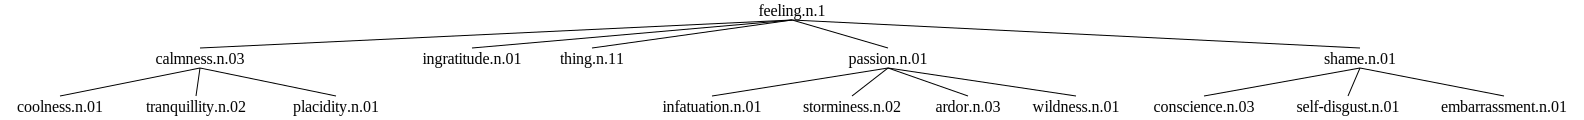

In [155]:
#t1_start = feelings[:20]
#t2_start = feelings[21:]

#trees[0]
#t1,t2 = dict(),dict()
#41 hyponyms
root_name = "feeling.n.1"
trees = make_trees(root_name)
for t0 in trees:
    extend_tree(t0)
trees[0]

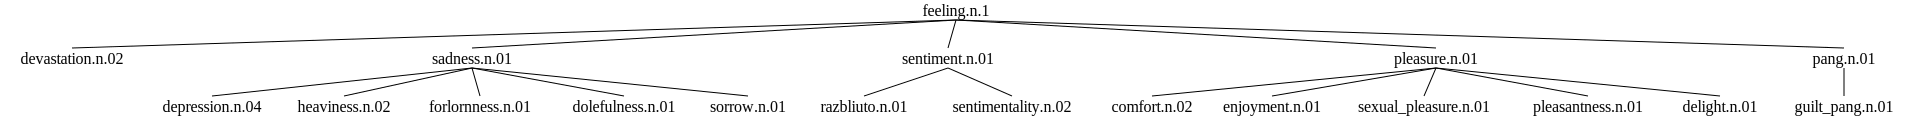

In [156]:
trees[1]

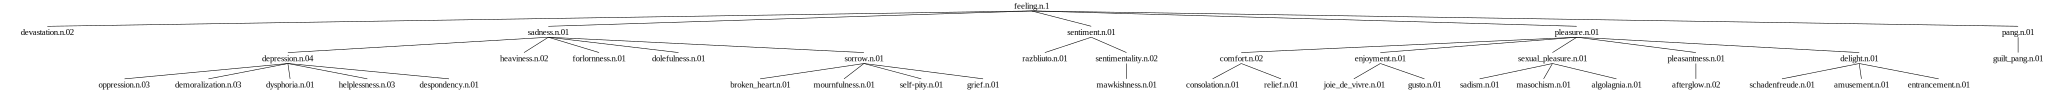

In [166]:
extend_tree(trees[1])
trees[1]

In [184]:
print(l[3])
trees[2][l[3]]

(0, 1)


'meekness.n.01'

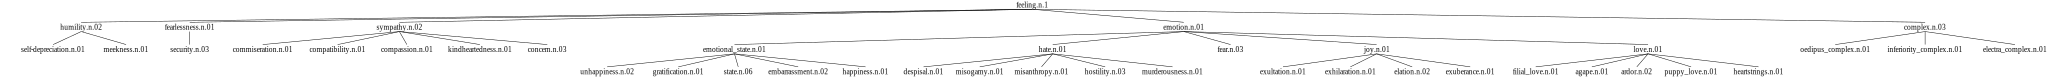

In [194]:
trees[2]

In [174]:
wn.synset("emotion.n.01").hyponyms()

[Synset('emotional_state.n.01'),
 Synset('hate.n.01'),
 Synset('fear.n.03'),
 Synset('joy.n.01'),
 Synset('love.n.01'),
 Synset('anxiety.n.02'),
 Synset('conditioned_emotional_response.n.01'),
 Synset('anger.n.01'),
 Synset('fear.n.01')]

In [168]:
em_trees = make_trees("emotion.n.01")

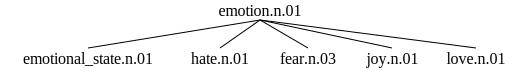

In [173]:
em_trees[0]

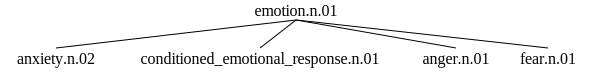

In [172]:
em_trees[1]

In [158]:
em_state = em_tree[0]
#dir(em_state)

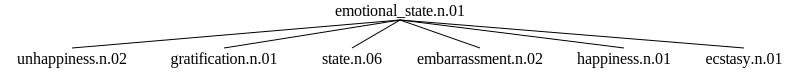

In [159]:
em_state_trees = make_trees(em_state.label(),inc=6)
for t in em_state_trees:
    display(t)
    print()

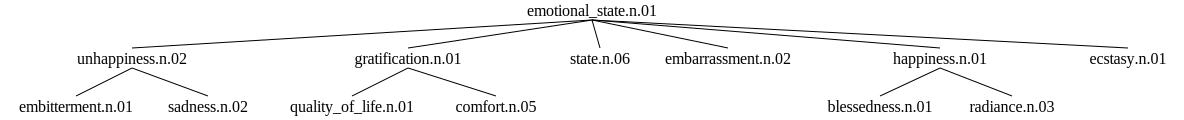

In [161]:
extend_tree(em_state_trees[0])
em_state_trees[0]

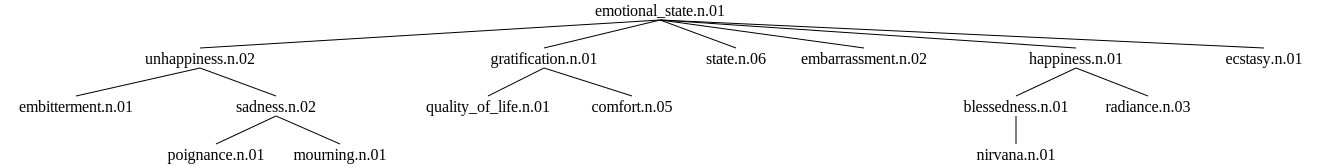

In [163]:
extend_tree(em_state_trees[0])
em_state_trees[0]

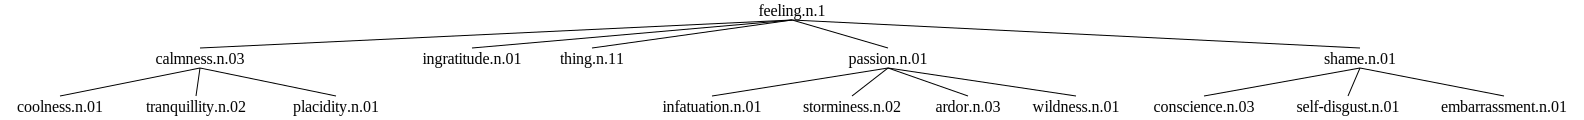

In [164]:
trees[0]

## The non-NLTK Python wrapper for wordnet

For comparison with [wn (non NLTK Python wrapper for Wordnet).](https://wn.readthedocs.io/en/latest/index.html)

It looks like there are two paths to the root, the second beginning right after the first occurrence of the root `entity.n.01`.  This despite the fact that tracing hypernyms from one sense:

In [251]:
get_hypers_iter_list(wn.synsets("dog","n")[0])

[Synset('domestic_animal.n.01'),
 Synset('canine.n.02'),
 Synset('animal.n.01'),
 Synset('carnivore.n.01'),
 Synset('organism.n.01'),
 Synset('placental.n.01'),
 Synset('living_thing.n.01'),
 Synset('mammal.n.01'),
 Synset('whole.n.02'),
 Synset('vertebrate.n.01'),
 Synset('object.n.01'),
 Synset('chordate.n.01'),
 Synset('physical_entity.n.01'),
 Synset('animal.n.01'),
 Synset('entity.n.01'),
 Synset('organism.n.01'),
 Synset('living_thing.n.01'),
 Synset('whole.n.02'),
 Synset('object.n.01'),
 Synset('physical_entity.n.01'),
 Synset('entity.n.01')]

## from the nouns to the other parts of speech (a and v)

We use the stemmer to get to synsets that are morphologically related to emotionm nouns
and are adjectives.  Highly porous but a start.

nltk stemmers

1. ISRIStemmer: For Arabic
2. Lancaster stemmer:  agressive, recursive curious,curiousity,curio -> cury
3. Porter stemmer: popular Does work. curious,curiousity,curio -> cury

In [319]:
stemmers

['ISRIStemmer',
 'LancasterStemmer',
 'PorterStemmer',
 'RSLPStemmer',
 'RegexpStemmer',
 'SnowballStemmer',
 'StemmerI']

The code below really doesnt work well since it assumes the output of the stemmer is a word,
which it often isn't.  A better approach follows:

In [127]:
#pos="v"
#pos = "a"

stemmers = [nm for nm in dir(nltk) if "temmer" in nm]
#stemmer = nltk.PorterStemmer()
stemmer = nltk.LancasterStemmer()
# This needs a regexp that defines endings to be stripped
# but knows diddly aboiut English spelling rules
# so given "ed$" and "jarred" it will return "jarr"
#stemmer = nltk.RegexpStemmer()
# RThese both seem to be lingusitcially cuatious stemmers.
# Not approrpriate for this wild and wooly application.
#from nltk.stem import WordNetLemmatizer as wnl
#wnlstemmer = wnl()

def get_derivationally_related_words(ss_set, stemmer, pos="a"):
    new_pos_ss_set = []
    for ss1 in ss_set:
        #for ss2 in wn.synsets(stemmer.stem(ss1.name()),"a"):
        for l in ss1.lemmas():
            #[l.name() for l in sadness_ss.lemmas()]
            for ss_res in wn.synsets(stemmer.stem(l.name()),pos):
                new_pos_ss_set.append(ss_res)
    return new_pos_ss_set

def ss_set_to_word_set (ss_set):
    return sorted(list(set([nm for ss in ss_set for nm in ss.lemma_names()])))

In [128]:
emotion_adjectives_ss_set = get_derivationally_related_words(feeling_nouns, stemmer, pos="a")

emotion_verbs_ss_set = get_derivationally_related_words(feeling_nouns, stemmer, pos="v")

In [157]:
print(len(emotion_adjectives_ss_set))

373


In [221]:
emotion_noun_words = ss_set_to_word_set(feeling_nouns)
emotion_adjective_words = ss_set_to_word_set(emotion_adjectives_ss_set)
emotion_verb_words = ss_set_to_word_set(emotion_verbs_ss_set)

In [222]:
len(emotion_noun_words), len(emotion_adjective_words), len(emotion_verb_words)

(804, 529, 985)

Observation: a lot of these verbs are of the "cause to have emotion" variety, like "aggravate".  Some are noise ("abandon").  Many are just puzzling

In [223]:
emotion_verb_words

['abandon',
 'abase',
 'abash',
 'abide',
 'abide_by',
 'accommodate',
 'accomplish',
 'accost',
 'acerbate',
 'ache',
 'act',
 'act_as',
 'action',
 'addict',
 'adjourn',
 'affect',
 'affirm',
 'affright',
 'aggress',
 'agitate',
 'agree',
 'ail',
 'alarm',
 'alert',
 'alien',
 'alienate',
 'alight',
 'allege',
 'amaze',
 'anger',
 'angle',
 'anguish',
 'animate',
 'anneal',
 'annoy',
 'anticipate',
 'appal',
 'appall',
 'apprehend',
 'arouse',
 'ask',
 'assault',
 'assert',
 'astonish',
 'astound',
 'atone',
 'attach',
 'attack',
 'attaint',
 'augur',
 'auspicate',
 'aver',
 'avow',
 'await',
 'awe',
 'back_away',
 'back_out',
 'badmouth',
 'baffle',
 'ball_over',
 'bang',
 'barrack',
 'bash',
 'bask',
 'be',
 'be_given',
 'be_intimate',
 'be_on_cloud_nine',
 'beam',
 'bear',
 'bear_on',
 'bear_upon',
 'beat',
 'beat_out',
 'beatify',
 'becalm',
 'becharm',
 'become_flat',
 'bed',
 'bedaze',
 'bedazzle',
 'bedevil',
 'beg',
 'begrudge',
 'beguile',
 'belong',
 'belong_to',
 'belt_alo

## Experiment with using wheels and axles

In [162]:
emotion_satellites = [a for a in emotion_adjectives_ss_set if a.pos()=="s"]

In [163]:
head, satellites, ant_wheels

extended_emotion_satellites = set()
for ss in emotion_satellites:
    (h,sats, ants) = get_wheels_and_axle(ss)
    extended_emotion_satellites.add(h)
    extended_emotion_satellites.update(sats)
    extended_emotion_satellites.update(elem for sxl in ants for elem in sxl)
    

In [164]:
print(len(emotion_adjectives_ss_set))

373


In [165]:
print(len(emotion_satellites))
print(len(extended_emotion_satellites))

286
2048


In [167]:
extended_emotion_adjective_words = ss_set_to_word_set(extended_emotion_satellites)
print(len(extended_emotion_adjective_words))

3466


In [170]:

extended_emotion_adjective_words = sorted(list(extended_emotion_adjective_words))
with open("expressive_corpora/extended_emotion_adjectives_wn.txt","w") as ofh:
    for adj in extended_emotion_adjective_words:
        print(adj,file=ofh)

## Stemmers redux

A more realistic picture of what the stemmers do:

In [896]:
examples = ("destruction destroy destructible indestructible curiousity curious emblematic" +\
            " emblem orientation orient furious fury abstemious abstain" +\
            " fleece undoable government govern aviate aviation").split()
port,snow,lanc = nltk.PorterStemmer(),nltk.SnowballStemmer("english"),nltk.LancasterStemmer()
banner = f" {'Word':<15}  {'Port':<15}  {'Snow':<15} {'Lanc':<15} "
print(banner)
print("="*len(banner))
for wd in examples:
    #print(wd)
    print(f"{wd:<15} {port.stem(wd):<15}  {snow.stem(wd):<15} {lanc.stem(wd):<15}")

 Word             Port             Snow            Lanc            
destruction     destruct         destruct        destruct       
destroy         destroy          destroy         destroy        
destructible    destruct         destruct        destruct       
indestructible  indestruct       indestruct      indestruct     
curiousity      curious          curious         cury           
curious         curiou           curious         cury           
emblematic      emblemat         emblemat        emblem         
emblem          emblem           emblem          emblem         
orientation     orient           orient          ory            
orient          orient           orient          ory            
furious         furiou           furious         fury           
fury            furi             furi            fury           
abstemious      abstemi          abstemi         abstemy        
abstain         abstain          abstain         abstain        
fleece          fleec 

In [291]:
from collections import defaultdict
stem_dict = defaultdict(set)
#stemmer = nltk.PorterStemmer()
#stemmer = nltk.LancasterStemmer()

def update_stem_dict (ss_container):
    for ss in ss_container:
        for lname in ss.lemma_names():
            stem_name = stemmer.stem(lname)
            stem_dict[stem_name].add(lname)
            
            
def update_stem_dict_all_pos ():
    wn_nouns = wn.all_synsets('n')
    update_stem_dict (wn_nouns)
    wn_verbs = wn.all_synsets('v')
    update_stem_dict (wn_verbs)
    wn_adjectives = wn.all_synsets('a')
    update_stem_dict (wn_adjectives)

In [292]:
update_stem_dict_all_pos ()

Overstemming examples:

In [930]:
stemmer.stem("elation")

'el'

In [1138]:
stem_dict["el"]

{'EL',
 'ELA',
 'Elagatis',
 'Elia',
 'Elul',
 'el',
 'elan',
 'elate',
 'elated',
 'elater',
 'elating',
 'elation',
 'element',
 'elemental',
 'elementary',
 'elements',
 'ell'}

In [928]:
wn.synsets("elation","n")[0] in wn_nouns

True

In [433]:
stem_dict["er"]

{'ER',
 'ERA',
 'Er',
 'Ericales',
 'Eris',
 'Erivan',
 'era',
 'eristic',
 'eristical',
 'err',
 'errancy',
 'errant',
 'erratic',
 'erring',
 'error'}

In [1141]:
for (k,v) in stem_dict.items():
    if len(v) > 6 and len(k) > 4:
        print(f"{k:<10} {len(v):>2}  {" ".join(v)}")

abstract   10  abstractedness abstractness abstractionism abstract abstracted abstraction abstracter abstractor abstractionist abstractive
object     10  objectionable objector objection objectify object objectification objective objectionableness objectivity objectiveness
person     16  personable personation personification persona personalise personify personableness personalize personality person personate personage personalised personhood personal personalized
individ    11  individualization individualised individuality individualistic individualise individualized individualisation individual individualist individualism individualize
plant       8  planted Plantation plantar plantation planting plant plantal planter
subst       9  substrate substantival substantial substantiality substantive substance substation substring substantialness
artic      10  article articulated articulary articled articulation articulate articulateness articulative articulator articulatory
process    1

Next step: filter results back to word, pos pairs known in WordNet

In [293]:
legal_poses = ("a","v", "n")

def make_word2stem_dict():
    """
    key is a word pos pairs; val is the unique stem
    for that pair.
    """
    word2stem_dict = dict()
    for (stem0, word_set) in stem_dict.items():
        if len(stem0) < 3:
            continue
        for word in word_set:
            for pos in legal_poses:
                if wn.synsets(word,pos):
                    if (word,pos) in word2stem_dict:
                        raise Exception("Ambiguous stem for {word} {pos} {stem0} {word2stem_dict[(word,pos)]}")
                    word2stem_dict[(word,pos)] = stem0
    return word2stem_dict 

word2stem_dict  = make_word2stem_dict()

In [294]:
word2stem_dict[("aviation","n")]

'avy'

In [295]:
wn.synsets("elation","n")

[Synset('elation.n.01'), Synset('elation.n.02')]

Demoing the idea of the above mapping:

In [892]:

def find_poses(word):
    return [pos for pos in "a v n".split() if wn.synsets(word,pos)]
    
for stem in ["commun","fruit", "intern", "interpret"]:
    for word in sorted(list(stem_dict[stem])):
        pos_list = find_poses(word)
        print(f"{word:<20}   {stem:<10} {' '.join(pos_list)}")
    print()

Communion              commun     n
Communist              commun     a n
communalism            commun     n
commune                commun     v n
communicant            commun     n
communicating          commun     v n
communication          commun     n
communications         commun     n
communicativeness      commun     n
communicator           commun     n
communion              commun     n
communique             commun     n
communisation          commun     n
communism              commun     n
communist              commun     a n
community              commun     n
communization          commun     n

fruit                  fruit      v n
fruitage               fruit      n
fruiterer              fruit      n
fruitfulness           fruit      n
fruition               fruit      n

International          intern     a n
Internationale         intern     n
intern                 intern     v n
internalisation        intern     n
internality            intern     n
internalizat

In [887]:
word2stem_dict[("aviation","n")]

'avy'

Find verbs related to the noun aviation:

In [1143]:
st_avy = word2stem_dict[("aviation","n")]
for wd in stem_dict[st_avy]:
    for ss in wn.synsets(wd,"v"):
        for l in ss.lemmas():
            print(l.name())
        #print(lem.lemmas())

fly
aviate
pilot


In [296]:
wn_absolute_root = wn.synset("entity.n.01")

def get_related_lemmas(word,pos1,pos2,upper_bound=None):
    results = set()
    try:
        st_avy = word2stem_dict[(word,pos1)]
    except KeyError:
        return []
    for wd in stem_dict[st_avy]:
        for ss in wn.synsets(wd,pos2):
            if upper_bound is not None and upper_bound in get_hypers_iter(ss):
                for l in ss.lemmas():
                    results.add(l)
            elif upper_bound is None:
                for l in ss.lemmas():
                    results.add(l)
    return results

In [297]:
get_related_lemmas("aviation","n","v")

{Lemma('fly.v.03.aviate'), Lemma('fly.v.03.fly'), Lemma('fly.v.03.pilot')}

In [890]:
get_related_lemmas("fly","v","a")

{Lemma('flying.s.02.fast'),
 Lemma('fast-flying.s.01.fast-flying'),
 Lemma('fly.s.01.fly'),
 Lemma('fast-flying.s.01.flying'),
 Lemma('flying.s.02.quick')}

In [533]:
get_related_lemmas("aviate","v","n",upper_bound=wn_absolute_root)

{Lemma('aviator.n.01.aeronaut'),
 Lemma('air_travel.n.01.air'),
 Lemma('aviation.n.01.air_power'),
 Lemma('air_travel.n.01.air_travel'),
 Lemma('aviator.n.01.airman'),
 Lemma('aviation.n.03.airmanship'),
 Lemma('aviary.n.01.aviary'),
 Lemma('aviation.n.01.aviation'),
 Lemma('aviator.n.01.aviator'),
 Lemma('aviary.n.01.bird_sanctuary'),
 Lemma('aviator.n.01.flier'),
 Lemma('aviator.n.01.flyer'),
 Lemma('aviary.n.01.volary')}

In [581]:
ss = wn.synset("happiness.n.01")

In [583]:
ss.lemma_names()

['happiness', 'felicity']

In [301]:
from collections import defaultdict
import sys

class STD ():

    def __enter__(self):
        return sys.stdout
    
    def __exit__ (self,a,b,c):
        return 

std_inst = STD()


def make_noun2related_adj_dict():
    noun2related_adj_dict = defaultdict(set)
      
    for ss in feeling_nouns:
        #for ss in [wn.synset('happiness.n.01')]:
        nm = ss.name()
        for ln in ss.lemma_names():
            #print(nm, ln,file=ofh,end="\n   ")
            for rel_l in get_related_lemmas(ln,"n","a"):
                #print(rel_l.name(),file=ofh,end=" ")
                noun2related_adj_dict[nm].add(rel_l)
            #print("\n",end="",file=ofh)
        # Guarantees at least an empty set entry for ln
        noun2related_adj_dict[nm]
    return noun2related_adj_dict



def get_dict_yield(dd):
    """
    dd is a dict with container values
    """
    L = list(dd.items())
    S = set()
    for (lem, wd_set) in L:
        S.update(wd_set)
    return S

def get_lemma_string(lem):
    return f"{lem.synset().name()}.{lem.name()}"

Retired code in next cell:

In [3]:
def old_make_noun2related_adj_dict(fn=None):
    noun2related_adj_dict = defaultdict(set)
    
    if fn is None:
        entry = STD()
    else:
        entry = open(fn,"w") 
        
    with entry as ofh:
        for ss in feeling_nouns:
            #for ss in [wn.synset('happiness.n.01')]:
            nm = ss.name()
            for ln in ss.lemma_names():
                print(nm, ln,file=ofh,end="\n   ")
                for rel_l in get_related_lemmas(ln,"n","a"):
                    print(rel_l.name(),file=ofh,end=" ")
                    noun2related_adj_dict[nm].add(rel_l.name())
                print("\n",end="",file=ofh)
    return noun2related_adj_dict

def old_make_noun2related_adj_dict_simple():
    """
    This circumvents the stemmer, just using the lemmas attribute
    .derivationally_related_forms().  Much lower sized yield,
    but some new adjectival forms are found.  Presumably
    less noise as well.
    """
    noun2related_adj_dict2 = defaultdict(set) 
    for ss in feeling_nouns:
        nm = ss.name()
        for ln in ss.lemmas():
            ln_name = get_lemma_name(ln)
            #print(nm, ln,file=ofh,end="\n   ")
            related_forms = ln.derivationally_related_forms()
            for rel_l in related_forms:
                if rel_l.synset().pos() in ["a","s"]:
                    #print(f"{rel_l} [{rel_l.name()}]",file=ofh,end=" ")
                    #noun2related_adj_dict2[ln_name].add(get_lemma_name(rel_l))
                    noun2related_adj_dict2[ln_name].add(rel_l)
            # Guarantees at least an empoty set entry for ln
            noun2related_adj_dict2[ln_name]
    return noun2related_adj_dict2

def update_related_form_dict(ln_name, rel_l, dd, pos_seq, with_synset=False):
    ss_rel = rel_l.synset()
    if ss_rel.pos() in pos_seq:
        for ss_rel_l2 in rel_ss.lemmas():
            if with_synset:
                added = ss_rel_l2.synset.name()
            else:
                added = ss_rel_l2.name()
            dd[ln_name].add(added)

   


In [2]:
def make_noun2related_adj_dict():
    noun2related_adj_dict = defaultdict(set)
      
    for ss in feeling_nouns:
        #for ss in [wn.synset('happiness.n.01')]:
        nm = ss.name()
        for lem in ss.lemmas():
            ln = lem.name()
            lem_str = get_lemma_string(lem)
            #ln_name = get_lemma_name(ln)
            #print(nm, ln,file=ofh,end="\n   ")
            for rel_l in get_related_lemmas(ln,"n","a"):
                #noun2related_adj_dict[nm].add(rel_l.name())
                #update_related_form_dict(ln_name, rel_l.synset(), noun2related_adj_dict)
                update_related_form_dict(lem_str, rel_l.synset(), noun2related_adj_dict)
            # Guarantees at least an empty set entry for ln
            noun2related_adj_dict[lem_str]
    return noun2related_adj_dict


def make_noun2related_adj_dict_simple(pos_seq=("a","s"),with_synset=False):
    """
    This circumvents the stemmer, just using the lemmas attribute
    .derivationally_related_forms().  Much lower sized yield,
    but some new adjectival forms are found.  Presumably
    less noise as well.
    """
    noun2related_adj_dict2 = defaultdict(set) 
    for ss in feeling_nouns:
        nm = ss.name()
        for ln in ss.lemmas():
            ln_str = get_lemma_string(ln)
            #print(nm, ln,file=ofh,end="\n   ")
            related_forms = ln.derivationally_related_forms()
            for rel_l in related_forms:
                rel_ss = rel_l.synset()
                if rel_ss.pos() in pos_seq:
                    update_related_form_dict(ln_str, rel_ss, noun2related_adj_dict2,with_synset=with_synset)
                    #print(f"{rel_l} [{rel_l.name()}]",file=ofh,end=" ")
                    #for ss_rel_l2 in ss_rel.lemmas():
                    #    noun2related_adj_dict2[ln_name].add(ss_rel_l2.name())
                    #    #noun2related_adj_dict2[ln_name].add(get_lemma_name(ss_rel_l2))
                    #    #noun2related_adj_dict2[ln_name].add(rel_l)
            # Guarantees at least an empty set entry for ln
            noun2related_adj_dict2[ln_str]
    return noun2related_adj_dict2

def update_related_form_dict(ln_name, rel_ss, dd):
    for ln in rel_ss.lemma_names():
        dd[ln_name].add(ln)

def write_dict_to_file(ln_dict, fn=None):
    """
    This circumvents the stemmer, just using the lemmas attribute
    .derivationally_related_forms().  Much lower sized yield,
    but some new adjectival forms are found.  Presumably
    less noise as well.
    """
    #noun2related_adj_dict2 = defaultdict(set)
   
    if fn is None:
        entry = STD()
    else:
        entry = open(fn,"w") 
 
    sorted_lns= sorted(ln_dict.keys())
    with entry as ofh:
        for nm in sorted_lns:
            #nm = ss.name()
            print(nm, file=ofh,end="\n   ")
            for wd in ln_dict[nm]:#ss.lemmas():
                #related_forms = ln.derivationally_related_forms()
                #for rel_l in related_forms:
                #    if rel_l.synset().pos() in ["a","s"]:
                #rel_l_name = f"{rel_l.synset().name()}.{rel_l.name()}"
                print(f"{wd}",file=ofh,end="\n   ")
                #noun2related_adj_dict2[nm].add(rel_l.name())
            print("\n",end="",file=ofh)

def update_set_valued_dict (dd1,dd2):
    """
    dd1 and dd2 have the same keys and setlike values
    unoin those setlike bvalues
    """
    for k in dd2:
        dd1[k].update(dd2[k])
        

In [318]:
noun2related_adj_dict22 = make_noun2related_adj_dict_simple()
adj_yield22 = get_dict_yield(noun2related_adj_dict22)
dd_yield22a = len(adj_yield22)
print(f"noun2related_adj_dict22 has {len(noun2related_adj_dict22)} noun lemmas with {dd_yield22a} related adjectives") 

noun2related_adj_dict22 has 856 noun lemmas with 613 related adjectives


In [319]:
noun2related_adj_dict22

defaultdict(set,
            {'ardor.n.03.ardor': set(),
             'ardor.n.03.ardour': set(),
             'ardor.n.03.fervor': set(),
             'ardor.n.03.fervour': set(),
             'ardor.n.03.fervency': {'ardent',
              'fervent',
              'fervid',
              'fiery',
              'impassioned',
              'perfervid',
              'torrid'},
             'ardor.n.03.fire': {'ardent',
              'fervent',
              'fervid',
              'fiery',
              'impassioned',
              'perfervid',
              'torrid'},
             'ardor.n.03.fervidness': {'ardent',
              'fervent',
              'fervid',
              'fiery',
              'impassioned',
              'perfervid',
              'torrid'},
             'worry.n.02.worry': set(),
             'worry.n.02.trouble': set(),
             'shamefacedness.n.01.shamefacedness': {'guilty',
              'hangdog',
              'shamed',
              'shamefaced',


In [1165]:
write_dict_to_file(noun2related_adj_dict22, fn="related_adjectives_high_quality.txt")

In [1175]:
noun2related_adj_dict11 = make_noun2related_adj_dict()
#adj_yield22 = get_dict_yield(noun2related_adj_dict22)
adj_yield11 = get_dict_yield(noun2related_adj_dict11)
dd_yield11 = len(adj_yield11)
print(f"noun2related_adj_dict11 has {len(noun2related_adj_dict11)} noun lemmas with {dd_yield11} related adjectives") 

noun2related_adj_dict11 has 856 noun lemmas with 2399 related adjectives


In [1177]:
len(adj_yield11 | adj_yield22)

2444

In [1178]:
len(set(noun2related_adj_dict22.keys()))

856

In [1179]:
len(noun2related_adj_dict11.keys())

856

In [1180]:
len(set(noun2related_adj_dict22.keys()).union(noun2related_adj_dict11.keys()))

856

In [1181]:
update_set_valued_dict (noun2related_adj_dict11,noun2related_adj_dict22)

In [1182]:
len(noun2related_adj_dict11.keys())

856

In [1183]:
adj_yield_merged = get_dict_yield(noun2related_adj_dict11)
len(adj_yield_merged)

2444

In [1184]:
write_dict_to_file(noun2related_adj_dict11, fn="related_adjectives_high_quality_or_by_stemmer.txt")

In [971]:
for ss in wn.synsets("desire","n"):
    ls = list(map(get_lemma_string, ss.lemmas()))
    ct11 = sum(1 for l in ls if l in noun2related_adj_dict11)
    ct22 = sum(1 for l in ls if l in noun2related_adj_dict22) 
    stats = f"lct {len(ls)} ct11 {ct11} ct22 {ct22}"
    print(ss, stats, ss.definition())

Synset('desire.n.01') lct 1 ct11 0 ct22 1 the feeling that accompanies an unsatisfied state
Synset('desire.n.02') lct 1 ct11 0 ct22 0 an inclination to want things
Synset('desire.n.03') lct 1 ct11 0 ct22 0 something that is desired


# Framenet

In [7]:
from nltk.corpus import framenet as fn

fn.lu(256).name
#'foresee.v'

'foresee.v'

In [8]:
fn.lu(256).definition
#'COD: be aware of beforehand; predict.'

'COD: be aware of beforehand; predict.'

In [9]:
fn.lu(256).frame.name
#'Expectation'

'Expectation'

In [10]:
fn.frame("Expectation")

frame (26): Expectation

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Expectation.xml

[definition]
  Words in this frame have to do with a Cognizer believing that
  some Phenomenon will take place in the future.  Some words in the
  frame (e.g. foresee.v) indicate that the Phenomenon is asserted
  also to be true, while others do not.  'Michael expected Abby to
  demand examples.' 'From the look on her face Michael expected
  that she would say she got the job.'
[semTypes] 0 semantic types

[frameRelations] 3 frame relations
  <Parent=Awareness -- Inheritance -> Child=Expectation>
  <Parent=Expectation -- Using -> Child=Predicting>
  <MainEntry=Omen -- See_also -> ReferringEntry=Expectation>

[lexUnit] 14 lexical units
  anticipate.v (253), await.v (254), expect.v (255), expectation.n
  (13081), foresee.v (256), foreseeable.a (3588), predict.v (257),
  predictable.a (3585), prediction.n (13082), premonition.n
  (13083), unexpected.a (13928), unforeseeable.a (3587),
 

In [1191]:
from nltk.corpus.reader.framenet import PrettyDict,PrettyList
list(map(PrettyDict, fn.lu(256).lexemes))
[{'POS': 'V', 'breakBefore': 'false', 'headword': 'false', 'name': 'foresee', 'order': 1}]

[{'POS': 'V',
  'breakBefore': 'false',
  'headword': 'false',
  'name': 'foresee',
  'order': 1}]

In [1193]:
# This verifies we have FN 1.7
ferels = fn.fe_relations()
len(ferels)

12393

#### The key steps LUs -> frame and frame -> LUs

In [1194]:
from operator import itemgetter
PrettyList(sorted(fn.frames_by_lemma(r'(?i)a little'), key=itemgetter('ID'))) 

[<frame ID=189 name=Quantified_mass>, <frame ID=2001 name=Degree>]

In [1206]:
#Here is form to frame functionality
L=sorted(fn.frames_by_lemma("inquire"), key=itemgetter('ID'))
PrettyList(L) 

[<frame ID=40 name=Questioning>, <frame ID=500 name=Criminal_investigation>]

In [1197]:
#Frames are just dictionaries
(L[0]).keys()

dict_keys(['cBy', 'cDate', 'name', 'ID', '_type', 'definition', 'definitionMarkup', 'FE', 'FEcoreSets', 'lexUnit', 'semTypes', 'frameRelations', 'URL'])

And here is the frame to lexeme functionality

In [1198]:
#frame -> lexunit dict
#
L[0].lexUnit

{'ask.v': <lu ID=8421 name=ask.v>, 'grill.v': <lu ID=627 name=grill.v>, 'inquire.v': <lu ID=628 name=inquire.v>, 'inquiry.n': <lu ID=629 name=inquiry.n>, 'interrogate.v': <lu ID=630 name=interrogate.v>, 'interrogation.n': <lu ID=631 name=interrogation.n>, 'query.n': <lu ID=632 name=query.n>, 'query.v': <lu ID=633 name=query.v>, 'question.n': <lu ID=634 name=question.n>, 'question.v': <lu ID=635 name=question.v>, 'questioning.n': <lu ID=636 name=questioning.n>, 'quiz.v': <lu ID=637 name=quiz.v>}

The lexunit object has valence info (under `subCorpus`:

In [1199]:
L[0].lexUnit["ask.v"]

lexical unit (8421): ask.v

[definition]
  COD: say something in order to obtain an answer or some
  information from someone
[frame] Questioning(40)

[POS] V

[status] FN1_Sent

[lexemes] ask/V

[semTypes] 0 semantic types

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/lu/lu8421.xml

[subCorpus] 13 subcorpora
  V-coordpass, V-intrans-adverb, V-invertquote, V-np-np, V-np-
  pother, V-np-ppother, V-other, V-pother, V-ppother, V-sbse,
  V-surepass, V-that-sfin, manually-added

[exemplars] 111 sentences across all subcorpora

In [1437]:
def lex2colexes (lex,result=None,allowed=None):
    if result is None:
        result = dict()
    frames = fn.frames_by_lemma(lex)
    if allowed is not None:
        frames = [frame for frame in frames if frame.name in allowed]
    for frame in frames:
        result[frame.name] = list(frame.lexUnit.keys())
    return result

In [1440]:
lex2colexes("inquire.v")

{'Criminal_investigation': ['inquiry.n',
  'probe.n',
  'investigate.v',
  'inquire.v',
  'probe.v',
  'investigation.n',
  'lead.n',
  'clue.n',
  'case.n'],
 'Questioning': ['grill.v',
  'inquire.v',
  'inquiry.n',
  'interrogate.v',
  'interrogation.n',
  'query.n',
  'query.v',
  'question.n',
  'question.v',
  'questioning.n',
  'quiz.v',
  'ask.v']}

noun_sample =[]
for (i,x) in enumerate(feeling_nouns):
    noun_sample.append(x.name()[:-3])

In [1262]:
feeling_frames = "Judgment Contrition Experiencer_focus Desiring Stimulus_focus".split()
frame.lexUnit.keys()
colex_dicts = [lex2colexes (lex,allowed=feeling_frames) for lex in noun_sample]

In [1263]:
form_yield = [form for  colex_dict in colex_dicts for form_list in colex_dict.values() for form in form_list]
len(form_yield),len(set(form_yield))

(4004, 366)

In [1264]:
adj_list = [adj[:-2] for  colex_dict in colex_dicts for form_list in colex_dict.values() for adj in form_list if adj.endswith(".a")]
adj_yield = set(adj_list)
len(adj_list),len(set(adj_yield))

(2570, 221)

In [1265]:
adj_yield

{'abominable',
 'absorbing',
 'admiring',
 'agape',
 'aggravating',
 'agonizing',
 'agreeable',
 'alarming',
 'alienating',
 'amazing',
 'amusing',
 'annoying',
 'appalling',
 'appreciative',
 'apprehensive',
 'approving',
 'astonishing',
 'astounding',
 'baffling',
 'beguiling',
 'bewildering',
 'bewitching',
 'blood-curdling',
 'boring',
 'bothersome',
 'breathtaking',
 'calm',
 'calming',
 'captivating',
 'charming',
 'cheering',
 'chilling',
 'comforting',
 'comical',
 'confusing',
 'consoling',
 'contemptuous',
 'contrite',
 'cool',
 'covetous',
 'critical',
 'dear',
 'delightful',
 'depressing',
 'derisive',
 'desired',
 'desirous',
 'devastating',
 'disagreeable',
 'disappointing',
 'disapproving',
 'discomfiting',
 'discomforting',
 'disconcerting',
 'discouraging',
 'disdainful',
 'disgusting',
 'disheartening',
 'disillusioning',
 'dismaying',
 'disorientating',
 'displeasing',
 'dissatisfied',
 'distasteful',
 'distressing',
 'disturbing',
 'dreadful',
 'droll',
 'dull',
 'd

This little run added 80 high quality adjectives

In [1253]:
print(len(adj_yield_merged))
print(len(adj_yield_merged|adj_yield))

2444
2524


The right way to add adjectives using FN.

In [306]:
feeling_frames = "Judgment Contrition Experiencer_focus Desiring Stimulus_focus".split()
all_lexes =  {lex for frame in feeling_frames for lex in list(fn.frame(frame).lexUnit.keys())}
adj_yield = {lex[:-2] for lex in all_lexes if lex.endswith(".a")}
noun_yield = {lex[:-2] for lex in all_lexes if lex.endswith(".n")}
verb_yield = {lex[:-2] for lex in all_lexes if lex.endswith(".v")}
len(adj_yield),len(noun_yield),len(verb_yield)

(221, 74, 67)

In [1287]:
noun_set = {n[:-2] for n in noun_sample}

In [1290]:
len(noun_sample),len(noun_yield.intersection(noun_set))

(445, 29)

In [1296]:
len(noun_set)

424

In [1295]:
len(noun_yield.union(noun_set))

469

What Framenet added:

In [1297]:
(noun_yield - noun_set)

{'accolade',
 'adoration',
 'appreciation',
 'aspiration',
 'blame',
 'charm [count]',
 'charm [mass]',
 'color',
 'contrition',
 'damnation',
 'desperation',
 'detestation',
 'disdain',
 'disrespect',
 'esteem',
 'exaltation',
 'fault',
 'hatred',
 'hunger',
 'impulse',
 'loathing',
 'lust',
 'mockery',
 'penitence',
 'pity',
 'recreation',
 'regret',
 'relaxation',
 'relish',
 'remorse',
 'reproach',
 'respect',
 'rest',
 'reverence',
 'scorn',
 'solace',
 'stigma',
 'stricture',
 'thirst',
 'vexation',
 'vilification',
 'wants',
 'will',
 'yearning',
 'yen'}

In [1302]:
len(adj_yield_merged),len(adj_yield_merged|adj_yield)

(2444, 2524)

What Framenet added (with what is sure an incomplete list of relevant frames)

In [1303]:
adj_yield-adj_yield_merged

{'admiring',
 'agreeable',
 'baffling',
 'bewildering',
 'blood-curdling',
 'breathtaking',
 'calming',
 'charming',
 'critical',
 'derisive',
 'disagreeable',
 'discomfiting',
 'discomforting',
 'disillusioning',
 'disorientating',
 'droll',
 'earth-shattering',
 'electrifying',
 'embittering',
 'empty',
 'enraging',
 'entertaining',
 'fazed',
 'fed up',
 'formidable',
 'fulfilling',
 'full',
 'ghastly',
 'hair-raising',
 'heart-rending',
 'heart-stopping',
 'heart-warming',
 'impressive',
 'intriguing',
 'invigorating',
 'jaw-dropping',
 'mind-boggling',
 'mind-numbing',
 'mystifying',
 'nerve-racking',
 'nice',
 'pacifying',
 'placating',
 'reassuring',
 'reluctant',
 'reprehensible',
 'reproachful',
 'rich',
 'saddening',
 'satisfied',
 'side-splitting',
 'sobering',
 'soothing',
 'spine-chilling',
 'spine-tingling',
 'spoiling',
 'startling',
 'stinging',
 'stressful',
 'striking',
 'taken',
 'tear-jerking',
 'thorny',
 'thrilling',
 'tiring',
 'tormenting',
 'traumatic',
 'trauma

In [1304]:
verb_yield

{'abhor',
 'abominate',
 'accuse',
 'ache',
 'admire',
 'adore',
 'applaud',
 'appreciate',
 'approve',
 'aspire',
 'blame',
 'boo',
 'care',
 'covet',
 'crave',
 'deify',
 'delight',
 'deplore',
 'desire',
 'despair',
 'despise',
 'detest',
 'disapprove',
 'disdain',
 'dislike',
 'dread',
 'envy',
 'esteem',
 'exalt',
 'fancy',
 'fault',
 'fear',
 'feel like',
 'grieve',
 'hanker',
 'hate',
 'hope',
 'hunger',
 'itch',
 'like',
 'loathe',
 'long',
 'love',
 'lust',
 'mock',
 'mourn',
 'pine',
 'pity',
 'prize',
 'regret',
 'repent',
 'resent',
 'respect',
 'revere',
 'rue',
 'scorn',
 'set store',
 'stigmatize',
 'strike a chord',
 'thirst',
 'value',
 'want',
 'will',
 'wish',
 'wish (that)',
 'yearn',
 'yen'}

In [307]:
def make_noun2related_verb_dict():
    noun2related_verb_dict = defaultdict(set)
      
    for ss in feeling_nouns:
        #for ss in [wn.synset('happiness.n.01')]:
        nm = ss.name()
        for ln in ss.lemma_names():
            #print(nm, ln,file=ofh,end="\n   ")
            for rel_l in get_related_lemmas(ln,"n","v"):
                #print(rel_l.name(),file=ofh,end=" ")
                noun2related_verb_dict[nm].add(rel_l)
            #print("\n",end="",file=ofh)
        # Guarantees at least an empoty set entry for ln
        noun2related_verb_dict[nm]
    return noun2related_verb_dict

noun2related_verb_dict = make_noun2related_verb_dict()

In [308]:
verb_yield22 = get_dict_yield(noun2related_verb_dict)
len(verb_yield22)
verb_set = {v.name() for v in verb_yield22}


In [309]:
len(verb_set)

2017

Only 12 verbs were added:

The multi word expressions *feel like*, *strike a chord*, *set store*  are the best.

In [310]:
verb_yield  - verb_set

{'adore',
 'applaud',
 'boo',
 'deify',
 'deplore',
 'fault',
 'feel like',
 'mock',
 'set store',
 'stigmatize',
 'strike a chord',
 'wish (that)'}

In [1358]:
fer = fn.lus("stream")[1].frame.frameRelations[1]
fer.keys()

dict_keys(['subID', 'supID', 'subFrameName', 'superFrameName', 'ID', '_type', 'feRelations', 'type', 'superFrame', 'Neutral', 'subFrame', 'Perspectivized'])

In [1363]:
fer['subFrameName'],fer['superFrameName'],fer["Perspectivized"],fer["Neutral"]

('Quantified_mass',
 'Measure_scenario',
 frame (189): Quantified_mass
 
 [URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Quantified_mass.xml
 
 [definition]
   This frame contains transparent nouns (and some adjectives)
   denoting quantities of a Mass or of Individuals. As opposed to
   aggregate words such as group, set, these Quantity do not have a
   status as Wholes on their own.   'He found them in the deluge of
   papers on his desk.'  Initially, at least, we have annotated both
   Quantity of Masses and of Individuals in this frame, though we
   may split the frame along these lines later on.
 [semTypes] 0 semantic types
 
 [frameRelations] 2 frame relations
   <MainEntry=Quantified_mass -- See_also -> ReferringEntry=Quantity>
   <Neutral=Measure_scenario -- Perspective_on -> Perspectivized=Quantified_mass>
 
 [lexUnit] 58 lexical units
   a bit.n (13797), a few.art (13370), a little.n (14733), a lot.n
   (13232), abundance.n (3333), all.a (13747), amount.n (338

In [1342]:
#fn.lus("stream.n")[1].frame.keys()
#dict_keys(['cBy', 'cDate', 'name', 'ID', '_type', 'definition', 'definitionMarkup', 'FE', 
#'FEcoreSets', 'lexUnit', 'semTypes', 'frameRelations', 'URL'])
qtfd_mass = fn.lus("stream.n")[1].frame
qtfd_mass["frameRelations"]

[<MainEntry=Quantified_mass -- See_also -> ReferringEntry=Quantity>, <Neutral=Measure_scenario -- Perspective_on -> Perspectivized=Quantified_mass>]

### All frames

In [9]:
all_frames = fn.frames()

FrameNet 1.7

In [10]:
len(all_frames)

1221

## Lexicon

A lemma is a sense form pair as in WordNet, but a sense here means an assignment of roles
within a frame.   In Framenet lemmas are called **lexUnits**.  So when we note that a lexical form, even
a lexical form with an assigned part of speech, may have several frames, we are saying it has several lexical
units (several senses) each with an assigned frame.

Note there are 7,000 or so frames yielding only 10,000 or so lexunit names but there are actually 13,500 or so
lex units.

In [11]:
vocab_list = [fn.lexUnit[lu] for fn in all_frames for lu in fn.lexUnit]
vocab = {lu.name for lu in vocab_list}

In [1444]:
len(vocab_list)

13572

In [1446]:
vocab_list[0].name

'abandon.v'

In [1372]:
len(vocab)

10462

In [1410]:
import re
from collections import Counter,defaultdict

pos_part = (r"(\..*)$")
pos_part_re = re.compile(pos_part)
ctr = Counter(pos_part_re.findall(lu.name)[0] for lu in vocab)
vocab_dict = defaultdict(set)
for v in vocab:
    vocab_dict[pos_part_re.findall(v.name)[0][1:]].add(v.name)

In [1415]:
vocab_dict.keys()

dict_keys(['v', 'n', 'a', 'prep', 'adv', 'idio', 'intj', 'num', 'c', 'scon', 'art', 'pron'])

In [1420]:
vocab_dict["idio"]

{'ago.idio',
 'be symbol.idio',
 'do time.idio',
 "dog (someone's) steps.idio",
 'from to.idio',
 'gain ground.idio',
 'give job.idio',
 'give notice.idio',
 'give thought.idio',
 'give try.idio',
 "hold (one's) tongue.idio",
 'in amount.idio',
 'in terms.idio',
 "jump (someone's) bones.idio",
 "make (someone's) acquaintance.idio",
 'make arrangements.idio',
 'make history.idio',
 'not a word.idio',
 'on authority.idio',
 'place weight.idio',
 'point out.idio',
 "pull (someone's) leg.idio",
 "pull the wool over (someone's) eyes.idio",
 'set ablaze.idio',
 'set alight.idio',
 "take (someone's) life.idio",
 "tip (someone's) hand.idio",
 'wait tables.idio',
 'with on.idio'}

## Corpus

In [1431]:
vocab_list  = list(vocab)

In [1428]:
lu0= vocab_list[0]
lu0.name

'abandon.v'

In [1432]:
lu0.frame.name

'Abandonment'

In [1430]:
lu0.exemplars

exemplar sentences for abandon.v in Abandonment:

[0] The bank has abandoned all plans to finance roads or logging in Cameroon 's forests , in keeping with its ` stringent policy to protect the rights of indigenous people . "
[1] Jamie Hill , prosecuting , said Stevenson and a friend took a Nova car from North Skelton and abandoned it in Nottingham .
[2] She had seen no reason to abandon it when she came to Medewich two years ago , even though she might now have been able to afford a car .
[3] Unfortunately , as a result of other priorities following the fall of France in June 1940 , the project was abandoned .
[4] Leeds Education Authority has abandoned plans for ` drastic " cuts in travel subsidies for some Catholic students .
[5] Moved to rectify this situation , he abandoned plans of working in the missionary field , and offered his services to the Netherlands Indies civil service .
[6] The council later abandoned its plans to widen the highway and the reversion passed to the first

In [1429]:
lu0.exemplars[3]

exemplar sentence (1489323):
[corpID] 111
[docID] 421
[paragNo] 216
[sentNo] 4
[aPos] 35759420

[LU] (14839) abandon.v in Abandonment

[frame] (2031) Abandonment

[annotationSet] 2 annotation sets

[POS] 22 tags

[POS_tagset] PENN

[GF] 2 relations

[PT] 2 phrases

[text] + [Target] + [FE]

Unfortunately , as a result of other priorities following the 
                ----------------------------------------------
                Explanation                                   
 
fall of France in June 1940 , the project was abandoned .
---------------------------   -----------     *********
                              Theme                     
 
 
 
[Agent:CNI]
 


POS asignments are by character spans (to allow for lex units with white space):

In [1447]:
lu0.exemplars[3].POS

[(0, 13, 'rb'),
 (14, 15, ','),
 (16, 18, 'in'),
 (19, 20, 'dt'),
 (21, 27, 'nn'),
 (28, 30, 'in'),
 (31, 36, 'jj'),
 (37, 47, 'nns'),
 (48, 57, 'VVG'),
 (58, 61, 'dt'),
 (62, 66, 'nn'),
 (67, 69, 'in'),
 (70, 76, 'NP'),
 (77, 79, 'in'),
 (80, 84, 'NP'),
 (85, 89, 'cd'),
 (90, 91, ','),
 (92, 95, 'dt'),
 (96, 103, 'nn'),
 (104, 107, 'VBD'),
 (108, 117, 'VVN'),
 (118, 119, 'sent')]

In [1452]:
lu0.exemplars[3].text[21:27]

'result'

#### Iterating through all frames

Plan for Framenet

1)  Iterate through frame list to find roots relative to all fers.  That is, they are not the parent in any fer.

For example, abandonment is not a root.  It has a parent Intentionally affect.

In [109]:
# Abandonmentframe fers
IntentionallyAffect = fn.frames_by_lemma(lu0.name)[0]["frameRelations"][0]["Parent"]
IntentionallyAffect

frame (230): Intentionally_affect

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Intentionally_affect.xml

[definition]
  An Agent causes a Patient to be affected, sometimes by a
  particular Means or by use of an Instrument.  'A professional
  dishwasher doesn't do dishes with a rag anymore!'
[semTypes] 0 semantic types

[frameRelations] 52 frame relations
  <Parent=Intentionally_act -- Inheritance -> Child=Intentionally_affect>
  <Parent=Intentionally_affect -- Inheritance -> Child=Abandonment>
  <Parent=Intentionally_affect -- Inheritance -> Child=Adjusting>
  <Parent=Intentionally_affect -- Inheritance -> Child=Apply_heat>
  <Parent=Intentionally_affect -- Inheritance -> Child=Appointing>
  <Parent=Intentionally_affect -- Inheritance -> Child=Arranging>
  <Parent=Intentionally_affect -- Inheritance -> Child=Arrest>
  <Parent=Intentionally_affect -- Inheritance -> Child=Attaching>
  <Parent=Intentionally_affect -- Inheritance -> Child=Attack>
  <Parent=Intentionally

IntentionallyAffect is not a root either.

In [1459]:
IntentionallyAffect["frameRelations"][0]["Parent"]

frame (198): Intentionally_act

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Intentionally_act.xml

[definition]
  This is an abstract frame for acts performed by sentient beings.
  It exists mostly for FE inheritance.  'I carried out the deed
  easily .'
[semTypes] 0 semantic types

[frameRelations] 59 frame relations
  <Parent=Event -- Inheritance -> Child=Intentionally_act>
  <Parent=Intentionally_act -- Inheritance -> Child=Activity_finish>
  <Parent=Intentionally_act -- Inheritance -> Child=Assemble>
  <Parent=Intentionally_act -- Inheritance -> Child=Assistance>
  <Parent=Intentionally_act -- Inheritance -> Child=Atonement>
  <Parent=Intentionally_act -- Inheritance -> Child=Attempt>
  <Parent=Intentionally_act -- Inheritance -> Child=Attempting_and_resolving_scenario>
  <Parent=Intentionally_act -- Inheritance -> Child=Attending>
  <Parent=Intentionally_act -- Inheritance -> Child=Avoiding>
  <Parent=Intentionally_act -- Inheritance -> Child=Bail_decision>
  <P

And so on:

The complete set of frame relation types. 

In [144]:
[fr_rel.name for fr_rel in (fn.frame_relation_types())]

['Causative_of',
 'Inchoative_of',
 'Inheritance',
 'Metaphor',
 'Perspective_on',
 'Precedes',
 'ReFraming_Mapping',
 'See_also',
 'Subframe',
 'Using']

The next two frame relation types capture the State -> Inchoative -> Causative
relation (cool.a, cool.v.intr, cool.v.tr).

In [156]:
[fr_rel for fr_rel in fn.frame_relations() if fr_rel.type.name == "Causative_of"][:5]

[<Causative=Apply_heat -- Causative_of -> Inchoative/state=Absorb_heat>,
 <Causative=Attaching -- Causative_of -> Inchoative/state=Becoming_attached>,
 <Causative=Cause_bodily_experience -- Causative_of -> Inchoative/state=Perception_body>,
 <Causative=Cause_change -- Causative_of -> Inchoative/state=Undergo_change>,
 <Causative=Cause_change_of_consistency -- Causative_of -> Inchoative/state=Change_of_consistency>]

In [157]:
[fr_rel for fr_rel in fn.frame_relations() if fr_rel.type.name == "Inchoative_of"][:5]

[<Inchoative=Becoming_a_member -- Inchoative_of -> Stative=Membership>,
 <Inchoative=Becoming_attached -- Inchoative_of -> Stative=Being_attached>,
 <Inchoative=Becoming_detached -- Inchoative_of -> Stative=Being_detached>,
 <Inchoative=Becoming_dry -- Inchoative_of -> Stative=Being_dry>,
 <Inchoative=Cause_change_of_phase -- Inchoative_of -> Stative=Substance_by_phase>]

In [158]:
[fr_rel for fr_rel in fn.frame_relations() if fr_rel.type.name == "ReFraming_Mapping"][:5]

[<Source=Activity_finish -- ReFraming_Mapping -> Target=Activity_stop>,
 <Source=Activity_start -- ReFraming_Mapping -> Target=Cause_to_start>,
 <Source=Adding_up -- ReFraming_Mapping -> Target=Amounting_to>,
 <Source=Appeal -- ReFraming_Mapping -> Target=Entering_of_plea>,
 <Source=Apply_heat -- ReFraming_Mapping -> Target=Soaking>]

In [159]:
[fr_rel for fr_rel in fn.frame_relations() if fr_rel.type.name == "Precedes"][:5]

[<Earlier=Achieving_first -- Precedes -> Later=Product_development>,
 <Earlier=Activity_finish -- Precedes -> Later=Activity_done_state>,
 <Earlier=Activity_ongoing -- Precedes -> Later=Activity_finish>,
 <Earlier=Activity_ongoing -- Precedes -> Later=Activity_pause>,
 <Earlier=Activity_ongoing -- Precedes -> Later=Activity_stop>]

In [161]:
[fr_rel for fr_rel in fn.frame_relations() if fr_rel.type.name == "See_also"][:5]

[<MainEntry=Appellations -- See_also -> ReferringEntry=Kinship>,
 <MainEntry=Appellations -- See_also -> ReferringEntry=Leadership>,
 <MainEntry=Apply_heat -- See_also -> ReferringEntry=Cooking_creation>,
 <MainEntry=Attempt_means -- See_also -> ReferringEntry=Attempt>,
 <MainEntry=Awareness -- See_also -> ReferringEntry=Certainty>]

In [311]:
from nltk.corpus import framenet as fn
#all_frames = fn.frames()
vocab_list = [fn.lexUnit[lu] for fn in fn.frames() for lu in fn.lexUnit]
#vocab = {lu.name for lu in vocab_list}
event = fn.frame("Event")

def parent_closure (frame,n=0,bd=100):
    res = [frame.name]
    for fer in frame.frameRelations:
        parent = fer.get("Parent", None)
        if parent is None:
            return res
        elif parent.name == frame.name:
            return res
        elif n > bd:
            return res
        else:
            res.extend(parent_closure(parent,n+1))
    return res

def is_root_old(frame):
    #parents = [fer.get("Parent", None) for fer in frame.frameRelations if fer.get("Parent", None).name != frame]
    parents=[]
    for fr_rel in frame.frameRelations:
        p  = fr_rel.get("Parent", None)
        if p is not None:
            # It IS a parent-child type fr_rel
            p_name = p.name
            if p_name != frame.name:
                # It's the child
                parents.append(p_name)
    if parents:
        return False
    else:
        return True
    
def is_root (frame):
    is_child = False
    for fr_rel in frame.frameRelations:
        
        p  = fr_rel.get("Child", None)
        if p is not None and p.name == frame.name:
            is_child=True
    if is_child:
        return False
    else:
        return True
    
    
def lex2colexes (lex,result=None,allowed=None):
    if result is None:
        result = dict()
    frames = fn.frames_by_lemma(lex)
    if allowed is not None:
        frames = [frame for frame in frames if frame.name in allowed]
    for frame in frames:
        result[frame.name] = list(frame.lexUnit.keys())
    return result

In [2]:
lu0=vocab_list[0]
v_frame = lu0.frame
#v_frame = fn.frame("Transitive_action")
cl = parent_closure (v_frame)

In [3]:
cl

['Abandonment', 'Intentionally_affect', 'Intentionally_act', 'Event']

In [4]:
v_frame

frame (2031): Abandonment

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Abandonment.xml

[definition]
  An Agent leaves behind a Theme effectively rendering it no longer
  within their control or of the normal security as one's property.
  'Carolyn abandoned her car and jumped on a red double decker
  bus.'  'Perhaps he left the key in the ignition'  'Abandonment of
  a child is considered to be a serious crime in many
  jurisdictions.'  There are also metaphorically used examples:
  'She left her old ways behind .'
[semTypes] 0 semantic types

[frameRelations] 1 frame relations
  <Parent=Intentionally_affect -- Inheritance -> Child=Abandonment>

[lexUnit] 5 lexical units
  abandon.v (14839), abandoned.a (14843), abandonment.n (14842),
  forget.v (15317), leave.v (14841)

[FE] 12 frame elements
            Core: Agent (12338), Theme (12339)
      Peripheral: Degree (14482), Duration (12343), Manner (12342), Means (15920), Place (12340), Purpose (15921), Time (12341)
 

In [177]:
#roots = [rt for fm in fn.frames() for rt in parent_closure(fm)[-1:]]
roots = [fm.name for fm in fn.frames() if is_root(fm)]

In [92]:
len(set(roots))

201

In [312]:
#'Awareness_situation',
#roots[50:100]
# "Event",'Experiencer_focus', 'Importance',
#roots[50:100]
# 'Mental_activity','Mental_stimulus_stimulus_focus', "Possession", "Opinion"
#roots[100:150]
# 'Reciprocality','Stimulus_focus','Subjective_temperature','Undergoing_scenario'
#roots[150:201]
def get_lexes_from_frame_list (frame_list):
    return {frame_name: get_lexes_from_frame(fn.frame(frame_name))}

def get_lexes_from_frame_old(frame,seen=None,n=0):
    
    print(frame.name)
    if seen is None:
        seen=[]
    #if frame.name in seen:
    #    return []
    if n > 2:
        return []
    res = []
    for (lu_name, lu) in frame.lexUnit.items():
        res.append(lu_name)
        #res.extend([frame2 for fr_rel in frame.frameRelations 
        #           for frame2 in get_lexes_from_frame(fr_rel.Child)])
        for fr_rel in frame.frameRelations:
            if "Child" in fr_rel and fr_rel["Parent"].name not in seen and fr_rel["Child"].name not in seen:
                new_seen = seen + [frame.name]
                res.extend(get_lexes_from_frame(fr_rel.Child,seen=new_seen,n=n+1))
    return res


def get_lexes_from_frame(frame,res=None,seen=None,n=0):
    
    #print(n,frame.name)
    if res is None:
        res =[]
    if seen is None:
        seen = []
    seen.append(frame.name)
    #if n > 2:
    #    return res
    for (lu_name, lu) in frame.lexUnit.items():
        res.append(lu_name)
        #res.extend([frame2 for fr_rel in frame.frameRelations 
        #           for frame2 in get_lexes_from_frame(fr_rel.Child)])
        #print("Len fr_rels", len(frame.frameRelations))
    for fr_rel in frame.frameRelations:
        if "Child" in fr_rel and fr_rel["Child"].name not in seen:
            res = get_lexes_from_frame(frame=fr_rel.Child,res=res,seen=seen,n=n+1)
    return res
        
def find_path_from_frame(frame,target, path = None, seen=None,n=0):
    """
    Find parent-child loinks from frame to target lu:
    Example:
     
     find_path_from_frame(fn.frame("Experiencer_focus"), "enemy.n")
    """

    if seen is None:
        seen = []
    if path is None:
        path = []
    seen.append(frame.name)
    
    for (lu_name, lu) in frame.lexUnit.items():
        if lu_name == target:
            return ' '.join(path + [frame.name])
    for fr_rel in frame.frameRelations:
        if "Child" in fr_rel and fr_rel["Child"].name not in seen:
            new_path = path + [frame.name,fr_rel.type.name]
            res = find_path_from_frame(frame=fr_rel.Child,target=target,path=new_path,seen=seen,n=n+1)
            if res is not None:
                return res

 

In [313]:
Experiencer_focus_words = get_lexes_from_frame(fn.frame('Experiencer_focus'),res=None,n=0)
print(len(Experiencer_focus_words))
Experiencer_focus_words = set(Experiencer_focus_words)

455


In [314]:
Experiencer_focus_words

{'abhor.v',
 'abhorrence.n',
 'ablution.n',
 'abominate.v',
 'absorbed.a',
 'ache.v',
 'acquiesce.v',
 'adoration.n',
 'adore.v',
 'affray.n',
 'against.prep',
 'agape.a',
 'aim.n',
 'aim.v',
 'airman.n',
 'altercation.n',
 'amazing.a',
 'ambition.n',
 'antipathy.n',
 'appalling.a',
 'apprehensive.a',
 'aspiration.n',
 'aspire.v',
 'astonishing.a',
 'astounding.a',
 'atrocious.a',
 'attack.v',
 'average.a',
 'awesome.a',
 'awful.a',
 'back.v',
 'backing.n',
 'bad idea.n',
 'bad.a',
 'bathe.v',
 'battle.n',
 'battle.v',
 'be supposed to.v',
 'bear.v',
 'beautiful.a',
 'believe (in).v',
 'belligerent.n',
 'bent.a',
 'best thing since sliced bread.n',
 'bias.n',
 'bias.v',
 'biased.a',
 'bout.n',
 'brawl.n',
 'brawl.v',
 'brush [hair].v',
 'brush [teeth].v',
 'bw.n',
 'calm.a',
 'capitulate.v',
 'captivated.a',
 'care.v',
 'cave in.v',
 'cave.v',
 'clash.n',
 'clash.v',
 'cleanse.v',
 'comb.v',
 'combat.n',
 'combatant.n',
 'comfort.n',
 'commando.n',
 'common.a',
 'compassion.n',
 'compr

Why is *enemy.n* in this list?  What does it have to do with experiencer focus predicates?

In [67]:
find_path_from_frame(fn.frame("Experiencer_focus"), "enemy.n", path = None, seen=None,n=0)

'Experiencer_focus Using Desirability Inheritance Desirable_event Using Taking_sides Using Hostile_encounter Using Friendly_or_hostile'

In [70]:
fn.frame("Desirable_event").frameRelations[1]

<Parent=Desirable_event -- Using -> Child=Taking_sides>

In [71]:
fn.frame("Desirable_event")

frame (1383): Desirable_event

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Desirable_event.xml

[definition]
  A particular State_of_affairs is desirable.  The State_of_affairs
  may be required to achieve a Purpose.  A set of Circumstances may
  be specified under which the assessment of desirability holds.
  'You should take the doses about 12 hours apart and at the same
  time each day.' ' If the metal is seriously rusted or warped, it
  should be repaired or replaced with a chimney top damper.' 'To
  ensure that, you should have no CLASSPATH set.'
[semTypes] 0 semantic types

[frameRelations] 5 frame relations
  <Parent=Desirability -- Inheritance -> Child=Desirable_event>
  <Parent=Desirable_event -- Using -> Child=Taking_sides>
  <Parent=Required_event -- Using -> Child=Desirable_event>
  <Source=Required_event -- ReFraming_Mapping -> Target=Desirable_event>
  <Neutral=Preferred_alternative_scenario -- Perspective_on -> Perspectivized=Desirable_event>

[lexUnit

In [72]:
fn.frame("Taking_sides")

frame (1306): Taking_sides

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Taking_sides.xml

[definition]
  A Cognizer has a relatively fixed positive or negative point of
  view towards an Issue.  A Side in a debate concerning an Issue or
  an Action of a Side may stand in for the Issue.  The Cognizer's
  Degree of alignment may also be specified.  'In interviews , it
  seems like everyone is completely against this expenditure .'
[semTypes] 0 semantic types

[frameRelations] 6 frame relations
  <Parent=Desirable_event -- Using -> Child=Taking_sides>
  <Parent=Opinion -- Using -> Child=Taking_sides>
  <Parent=Taking_sides -- Using -> Child=Giving_in>
  <Parent=Taking_sides -- Using -> Child=Hostile_encounter>
  <Parent=Taking_sides -- Using -> Child=Partiality>
  <Parent=Taking_sides -- Using -> Child=Protest>

[lexUnit] 18 lexical units
  against.prep (11499), back.v (13989), backing.n (14562), believe
  (in).v (15794), endorse.v (13711), for.prep (11498), in
  favor.

The Step from *Taking_sides* to *Hostile_encounter* is the step that loses the Cognizer frame element:

In [35]:
#fn.lexUnit("enemy.n")
Friendly_or_hostile = fn.frames_by_lemma("enemy.n")[0].frameRelations[0].Parent
Friendly_or_hostile

frame (93): Hostile_encounter

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Hostile_encounter.xml

[definition]
  This frame consists of words that describe a hostile encounter
  between opposing forces (Side_1 and Side_2, collectively
  conceptualizable as Sides) over a disputed Issue and/or in order
  to reach a specific  Purpose. '' 'He still wants to fight Mike
  Tyson in about 8 months.'  'Dennis Andries's European
  cruiserweight title clash against Akim Tafer of France in
  Beausoleil last February has been voted as the EBU's fight of the
  year.'
[semTypes] 0 semantic types

[frameRelations] 9 frame relations
  <Parent=Hostile_encounter -- Inheritance -> Child=Fighting_activity>
  <Parent=Intentionally_act -- Inheritance -> Child=Hostile_encounter>
  <Parent=Hostile_encounter -- Using -> Child=Firefighting>
  <Parent=Hostile_encounter -- Using -> Child=Friendly_or_hostile>
  <Parent=Hostile_encounter -- Using -> Child=Irregular_combatants>
  <Parent=Hostile_en

All this suggests teh frame relation based approach should give way to an fe-based
approach.  Find expressive-related fes.  Fiund associated frames.  Just
use the lexunits in that fra,e/  Dont do a recursive parent-to-child
search to find the lex units associated with frames, because , as demonstrated in the discussion
above, that introduces noise.

In [253]:
Stimulus_focus_words = get_lexes_from_frame(fn.frame('Stimulus_focus'),res=None,n=0)

In [28]:
len(Experiencer_focus_words)

441

In [37]:
Experiencer_focus_words

{'abhor.v',
 'abhorrence.n',
 'ablution.n',
 'abominate.v',
 'absorbed.a',
 'ache.v',
 'acquiesce.v',
 'adoration.n',
 'adore.v',
 'affray.n',
 'against.prep',
 'agape.a',
 'aim.n',
 'aim.v',
 'airman.n',
 'altercation.n',
 'amazing.a',
 'ambition.n',
 'antipathy.n',
 'appalling.a',
 'apprehensive.a',
 'aspiration.n',
 'aspire.v',
 'astonishing.a',
 'astounding.a',
 'atrocious.a',
 'attack.v',
 'average.a',
 'awesome.a',
 'awful.a',
 'back.v',
 'backing.n',
 'bad idea.n',
 'bad.a',
 'bathe.v',
 'battle.n',
 'battle.v',
 'be supposed to.v',
 'bear.v',
 'beautiful.a',
 'believe (in).v',
 'belligerent.n',
 'bent.a',
 'best thing since sliced bread.n',
 'bias.n',
 'bias.v',
 'biased.a',
 'bout.n',
 'brawl.n',
 'brawl.v',
 'brush [hair].v',
 'brush [teeth].v',
 'bw.n',
 'calm.a',
 'capitulate.v',
 'captivated.a',
 'care.v',
 'cave in.v',
 'cave.v',
 'clash.n',
 'clash.v',
 'cleanse.v',
 'comb.v',
 'combat.n',
 'combatant.n',
 'comfort.n',
 'commando.n',
 'common.a',
 'compassion.n',
 'compr

In [30]:
print(len(Stimulus_focus_words))
Stimulus_focus_words = set(Stimulus_focus_words)
Stimulus_focus_words 

186


{'abominable.a',
 'absorbing.a',
 'aggravating.a',
 'aggravation.n',
 'agonizing.a',
 'agreeable.a',
 'alarming.a',
 'alienating.a',
 'amazing.a',
 'amusing.a',
 'annoyance.n',
 'annoying.a',
 'appalling.a',
 'astonishing.a',
 'astounding.a',
 'baffling.a',
 'beguiling.a',
 'bewildering.a',
 'bewitching.a',
 'blood-curdling.a',
 'boring.a',
 'bothersome.a',
 'breathtaking.a',
 'calming.a',
 'captivating.a',
 'charm [count].n',
 'charm [mass].n',
 'charming.a',
 'cheering.a',
 'chilling.a',
 'color.n',
 'comforting.a',
 'comical.a',
 'confusing.a',
 'consoling.a',
 'cool.a',
 'dear.a',
 'delight.n',
 'delightful.a',
 'depressing.a',
 'devastating.a',
 'disagreeable.a',
 'disappointing.a',
 'discomfiting.a',
 'discomforting.a',
 'disconcerting.a',
 'discouraging.a',
 'disgusting.a',
 'disheartening.a',
 'disillusioning.a',
 'dismaying.a',
 'disorientating.a',
 'displeasing.a',
 'distasteful.a',
 'distressing.a',
 'disturbing.a',
 'dreadful.a',
 'droll.a',
 'dull.a',
 'earth-shattering.a'

In [23]:
Experiencer_words = set(Experiencer_focus_words).union(Stimulus_focus_words)
len(Experiencer_words)

619

In [24]:
Experiencer_words

{'abhor.v',
 'abhorrence.n',
 'ablution.n',
 'abominable.a',
 'abominate.v',
 'absorbed.a',
 'absorbing.a',
 'ache.v',
 'acquiesce.v',
 'adoration.n',
 'adore.v',
 'affray.n',
 'against.prep',
 'agape.a',
 'aggravating.a',
 'aggravation.n',
 'agonizing.a',
 'agreeable.a',
 'aim.n',
 'aim.v',
 'airman.n',
 'alarming.a',
 'alienating.a',
 'altercation.n',
 'amazing.a',
 'ambition.n',
 'amusing.a',
 'annoyance.n',
 'annoying.a',
 'antipathy.n',
 'appalling.a',
 'apprehensive.a',
 'aspiration.n',
 'aspire.v',
 'astonishing.a',
 'astounding.a',
 'atrocious.a',
 'attack.v',
 'average.a',
 'awesome.a',
 'awful.a',
 'back.v',
 'backing.n',
 'bad idea.n',
 'bad.a',
 'baffling.a',
 'bathe.v',
 'battle.n',
 'battle.v',
 'be supposed to.v',
 'bear.v',
 'beautiful.a',
 'beguiling.a',
 'believe (in).v',
 'belligerent.n',
 'bent.a',
 'best thing since sliced bread.n',
 'bewildering.a',
 'bewitching.a',
 'bias.n',
 'bias.v',
 'biased.a',
 'blood-curdling.a',
 'boring.a',
 'bothersome.a',
 'bout.n',
 '

##  Using the wordnet  adj wheel information to expand the set of adjective words

In [217]:
L[:10]

['envy.n',
 'calm.a',
 'abhorrence.n',
 'sacrifice.v',
 'believe (in).v',
 'desire.v',
 'should.v',
 'yen.n',
 'scuffle.v',
 'pine.v']

In [273]:
L = list(Experiencer_focus_words)
L_ss = [ss for w in  L if w[-1] == "a" for ss in wn.synsets(w[:-2],"a") if ss.pos()=="s"]
# filter out some highly ambiguous noise makers
L_ss = [ss for ss in L_ss if ss.lemmas()[0].name() not in ["hot", "in","good", "bad", "easy", "common", "neutral"]]
extended_experiencer_focus_adjectives_wn = sorted(list({ss2.name() for ss in L_ss for ss2 in get_wheels_and_axle(ss,return_set=True)}))
print(len(L),len(L_ss),len(expanded_L_ss))

441 284 1268


In [274]:
L2 = list(Stimulus_focus_words)
L2_ss = [ss for w in  L2 if w[-1] == "a" for ss in wn.synsets(w[:-2],"a") if ss.pos()=="s"]
# filter out some highly ambiguous noise makers
#L_ss = [ss for ss in L_ss if ss.lemmas()[0].name() not in ["hot", "in","good", "bad", "easy", "common", "neutral"]]
extended_stimulus_focus_adjectives_wn = sorted(list({ss2.name() for ss in L2_ss for ss2 in get_wheels_and_axle(ss,return_set=True)}))
print(len(L2),len(L2_ss),len(expanded_L2_ss))

186 217 1268


In [277]:
len(extended_stimulus_focus_adjectives_wn)

1268

In [265]:
expanded_L2_ss# == expanded_L_ss

['abashed.s.01',
 'abhorrent.s.01',
 'abject.s.01',
 'abject.s.02',
 'ablaze.s.03',
 'abominable.s.01',
 'abortive.s.01',
 'abounding.s.01',
 'absolute.s.02',
 'absorbefacient.s.01',
 'absorbent.a.01',
 'absorbing.s.01',
 'abundant.a.01',
 'acarpous.s.01',
 'accessary.s.01',
 'accessory.s.02',
 'accomplished.s.02',
 'accordant.a.01',
 'accordant.s.02',
 'according.s.01',
 'acerb.s.02',
 'aching.s.01',
 'acid-tasting.s.01',
 'acknowledged.s.02',
 'active.a.07',
 'adequate.s.03',
 'admirable.s.01',
 'admirable.s.02',
 'admired.s.01',
 'admonitory.s.01',
 'adorable.s.01',
 'adored.s.01',
 'adrenocorticotropic.s.01',
 'advanced.s.04',
 'affecting.s.01',
 'afflicted.s.01',
 'afflictive.s.01',
 'aggravating.s.01',
 'agitative.s.01',
 'agonized.s.01',
 'agonizing.s.01',
 'agreeable.a.01',
 'agreeable.s.03',
 'aguish.s.01',
 'ailing.s.01',
 'airheaded.s.01',
 'airsick.s.01',
 'alarming.a.01',
 'alienated.s.02',
 'alienating.s.01',
 'aligning.s.01',
 'alimentary.s.01',
 'aliquot.s.01',
 'alive.

Same thing for related adj list from feeling  Nouns

In [317]:
noun2related_adj_dict22.values() 

dict_values([set(), set(), set(), set(), {'fiery', 'ardent', 'perfervid', 'fervent', 'fervid', 'impassioned', 'torrid'}, {'fiery', 'ardent', 'perfervid', 'fervent', 'fervid', 'impassioned', 'torrid'}, {'fiery', 'ardent', 'perfervid', 'fervent', 'fervid', 'impassioned', 'torrid'}, set(), set(), {'shamed', 'hangdog', 'guilty', 'shamefaced', 'sheepish'}, {'shamefaced', 'sheepish'}, {'heavy'}, set(), set(), set(), set(), set(), set(), set(), {'plaintive', 'mournful'}, set(), set(), set(), set(), set(), set(), set(), set(), {'angry'}, {'hotheaded', 'hot-tempered', 'short-tempered', 'choleric', 'quick-tempered', 'irascible'}, set(), set(), set(), set(), set(), set(), {'nervy', 'overstrung', 'edgy', 'jittery', 'restive', 'highly_strung', 'jumpy', 'high-strung', 'uptight'}, {'uneasy'}, set(), set(), set(), set(), set(), set(), set(), set(), {'moody', 'temperamental'}, set(), set(), set(), set(), {'blue', 'down', 'downcast', 'grim', 'depressed', 'downhearted', 'down_in_the_mouth', 'gloomy', 'lo

In [320]:
noun2related_adj_dict22 = make_noun2related_adj_dict_simple()
adj_yield22 = get_dict_yield(noun2related_adj_dict22)
dd_yield22a = len(adj_yield22)
print(f"noun2related_adj_dict22 has {len(noun2related_adj_dict22)}"\
      f" noun lemmas with {dd_yield22a} related adjectives") 

noun2related_adj_dict22 has 856 noun lemmas with 613 related adjectives


In [321]:
noun2related_adj_dict22


defaultdict(set,
            {'ardor.n.03.ardor': set(),
             'ardor.n.03.ardour': set(),
             'ardor.n.03.fervor': set(),
             'ardor.n.03.fervour': set(),
             'ardor.n.03.fervency': {'ardent',
              'fervent',
              'fervid',
              'fiery',
              'impassioned',
              'perfervid',
              'torrid'},
             'ardor.n.03.fire': {'ardent',
              'fervent',
              'fervid',
              'fiery',
              'impassioned',
              'perfervid',
              'torrid'},
             'ardor.n.03.fervidness': {'ardent',
              'fervent',
              'fervid',
              'fiery',
              'impassioned',
              'perfervid',
              'torrid'},
             'worry.n.02.worry': set(),
             'worry.n.02.trouble': set(),
             'shamefacedness.n.01.shamefacedness': {'guilty',
              'hangdog',
              'shamed',
              'shamefaced',


In [316]:
rel_adjs_22 = [wn.synset(adj) for adj_list in noun2related_adj_dict22.values() for adj in adj_list]
extended_rel_adjs_22 = sorted(list({ss2.name() for ss in rel_adjs_22 for ss2 in get_wheels_and_axle(ss,return_set=True)}))
print(len(rel_adjs_22),len(extended_rel_adjs_22))

ValueError: not enough values to unpack (expected 3, got 1)

## Abortive fe relation expriment

Thoughts while compiling the fe list below:

1.  Medical frames out.  The only interesting case to think about  was Ailment->Medical_Condition->cold.n
    
    
    I have a cold.
   
    
    Why is this not an expressive? (On the most natural content, it is prompted by tbe speaker's 
    own internal perceptions.  Are we taking the line that it may be prompted by those perceptions
    [miserable headache] but is not a report of those perceptions?)
    
2.  Cognizer_agent -> Seeking -> feel.v (for), listen (for), dig (for). ThisWhy not an expressive. is the case to wonder 'bout:

    a.  I'm digging for worms.
    b.  Shh!  I'm listening for termites.
    
    Why not an expressive?  Especially b.  A report on an internal state.  Why is it descriptive/ascriptve
    rather than depictive?
    
3.  Faculty -> Grasp -> see.v
    
    I don't see what you're getting at.
    
    Report on cognitive state.  No perceptual, emotional, surprise.  This is the heart of it.  Within
    cognitive states we make a distinction between those that are wriggling to get out (internal to external
    moment) and those that are not (grasping, understanding).  The resultant state is internal?  Grasping
    leads to further thought.  Surprise leads to a gasp.
    
4. Expression -> {Emotion_heat,Facial_expression}
    
   The former is a bunch of verbs, the latter a bunch of nouns.  Consider 
   
   I'm seething.
   
   Not an expressive.  On the following grounds:  Most natural context is when speaker has
   just been asked how they are feeling about X.  In part because X has to be salient for this
   sentence to be natural.  But on the line where the property of being usable as an expressive
   is gradable, this is an indicator:  Dependent on prior contextual setup.  In others
   the word prefers contexts in which a description has been called for, and is used to
   supply one.
   
5. Information -> Trust -> trust.v

   a.  I trust you.
   b.  I trust John.
   
   (a) seems very likely to be an expression of an emotional state, one which could 
   result in greater bonding with the addressee; (b) certainly can be a description,
   so can (a), especially in a context inviting affirmation ("Will you let me handle this?")
   
6.  Judge -> {Rashnessness, Volubility}

    The *Rashness* frame has no expressives but has a lot of clear cases of adjectives imposing
    an external perspective on empotional states: *impatient.a, impetuous.a, rash.a*.  Ditto
    *Volubility* (*chatterbox, voluble,  terse*).
     
   
   

In [13]:
# A cobbled together list of FEs with known expressive frames
fe_string = \
"""
Cognizer,Cognizer_1,Cognizer_2,Cognizer_agent,Cognizers,Communicator,Complainer,Conveyed_emotion,
Desirability,Desirable_action,Desirable_situation,Desired_goal,Desired_state_of_affairs,Emotional_state,
Emotion,Expectation,Expected_entity,Expected_event,Expected_request,Experience,Experiencer,
Expressor,Faculty,Interested_party,Means_of_communication,Mental_content,Message,Opinion,
Requirement,Responsible_party,Seeker,Sentient_entity,Sleep_state,Speaker,Stimulus,Supporter
"""
fe_list = fe_string.replace("\n","").split(",")

#  The fes that brought these up are very noisy so just use the frames directly.
expr_frame_list = "Trust Importance Cognitive_impact Regard Estimating Be_in_agreement_on_assessment Catastrophe Desirable_event".split()



In [14]:
from collections import defaultdict
expressive_fes2frames_dict = defaultdict(set)
for fe_name in fe_list:
    expressive_fes2frames_dict[fe_name]
for fr in expr_frame_list:
    expressive_fes2frames_dict["Dummy_fe"].add(fr)

def collect_expressive_frames(expressive_frames_dict, lexical_frames_only=False):
    fe_set = set(expressive_frames_dict.keys())
    frame_lex_dict = defaultdict(set)
    frame_fe_dict = defaultdict(set)
    for frame in fn.frames():
        if lexical_frames_only and len(frame.lexUnit) == 0:
            continue
        try:
            frame_fes = frame.FE
        except:
            continue
        for fe in fe_set:
            if fe in frame_fes and frame_fes[fe].coreType != "Extra-Thematic":
                expressive_frames_dict[fe].add(frame.name)
                frame_lex_dict[frame.name].update(frame.lexUnit.keys())
                frame_fe_dict[frame.name].add(fe)
    return frame_lex_dict,frame_fe_dict

frame_lex_dict0,frame_fe_dict = collect_expressive_frames(expressive_fes2frames_dict)

expressive_frame_yield = {frame for fe,frame_set in expressive_fes2frames_dict.items() for frame in frame_set}
expressive_fes_yield = {lu for frame in expressive_frame_yield for lu in fn.frame(frame).lexUnit}
print(len(expressive_fes_yield))
#expressive_fes_yield

2391


In [17]:
import datetime

def get_ex (ex0):
    try:
        part1 = f"> {ex0['LU'].name} {ex0['frame'].name} corp{ex0['corpID']}_doc{ex0['docID']}_sent{ex0['sentNo']}_para{ex0['paragNo']}_aPos{ex0['aPos']}"
    except KeyError:
        part1 = f"> {ex0['LU'].name} {ex0['frame'].name}"
    start,end = ex0.frameAnnotation.Target[0]
    text = ex0.frameAnnotation.text  
    part2 = text[:start]+ "<" + ex0.frameAnnotation.text[start:end] + ">" + text[end:]
    return "\n".join([part1,part2+"\n"])

def write_minicorpus (frame_lex_dict,fn0,max_ex=20):
    today = datetime.date.today().__str__()
    filename = f"{fn0}_{today}.txt"
    ctr_lex,ctr_fm,ctr22=0,0,0
    with open(filename,'w') as ofh:
        for fm,lexset in frame_lex_dict.items():
            ctr_fm+=1
            for lex in lexset:
                ctr_lex += 1
                lu = fn.frame(fm).lexUnit[lex]
                for ex in lu.exemplars[:max_ex]:
                    ctr22 += 1
                    if ctr22%50 == 0:
                        print(f"{ctr_fm} frames {ctr_lex} LUs {ctr22} examples")
                    try:
                        print(get_ex(ex),file=ofh)
                    except:
                        print(f"bad ex {ctr22}")
                        print("\n", file=ofh)

def write_frame_corpus (frame_name, max_ex=20):
    today = datetime.date.today().__str__()
    filename = f"{frame_name}_minicorpus_{today}.txt"
    ctr_lex, ctr22=0,0
    frame = fn.frame(frame_name)
    with open(filename,'w') as ofh:
        LUs = frame.lexUnit
        for lex in LUs:
            ctr_lex += 1
            lu = LUs[lex]
            for ex in lu.exemplars[:max_ex]:
                ctr22 += 1
                if ctr22%50 == 0:
                    print(f"{ctr_lex} LUs {ctr22} examples")
                try:
                    print(get_ex(ex),file=ofh)
                except:
                    print(f"bad ex {ctr22}")
                    print("\n", file=ofh)

In [18]:
write_frame_corpus ("Experiencer_focus", max_ex=20)

4 LUs 50 examples
6 LUs 100 examples
9 LUs 150 examples
11 LUs 200 examples
14 LUs 250 examples
16 LUs 300 examples
19 LUs 350 examples
23 LUs 400 examples
25 LUs 450 examples
28 LUs 500 examples
31 LUs 550 examples
33 LUs 600 examples
38 LUs 650 examples
40 LUs 700 examples
65 LUs 750 examples


In [19]:
write_frame_corpus ("Stimulus_focus", max_ex=20)

3 LUs 50 examples
8 LUs 100 examples
10 LUs 150 examples
15 LUs 200 examples
21 LUs 250 examples
26 LUs 300 examples
28 LUs 350 examples
32 LUs 400 examples
35 LUs 450 examples
37 LUs 500 examples
40 LUs 550 examples
42 LUs 600 examples
46 LUs 650 examples
49 LUs 700 examples
52 LUs 750 examples
55 LUs 800 examples
59 LUs 850 examples
61 LUs 900 examples
65 LUs 950 examples
69 LUs 1000 examples
72 LUs 1050 examples
74 LUs 1100 examples
77 LUs 1150 examples
80 LUs 1200 examples
83 LUs 1250 examples
86 LUs 1300 examples
88 LUs 1350 examples
91 LUs 1400 examples
93 LUs 1450 examples
96 LUs 1500 examples
100 LUs 1550 examples
103 LUs 1600 examples
106 LUs 1650 examples
110 LUs 1700 examples
114 LUs 1750 examples
119 LUs 1800 examples
122 LUs 1850 examples
124 LUs 1900 examples
127 LUs 1950 examples
130 LUs 2000 examples
133 LUs 2050 examples
137 LUs 2100 examples
139 LUs 2150 examples
142 LUs 2200 examples
144 LUs 2250 examples
150 LUs 2300 examples
154 LUs 2350 examples
156 LUs 2400 examp

In [15]:
bad_frames = "Achieving_first Adducing Adding_up Age".split()
for fm in bad_frames:
    try:
        del frame_lex_dict0[fm]
    except:
        continue
write_minicorpus (frame_lex_dict0,"fe_driven_frame_collection")

In [358]:
ex0 = exemplars[0]

In [360]:
ex0.keys()

dict_keys(['corpID', 'docID', 'sentNo', 'paragNo', 'aPos', 'ID', '_type', 'annotationSet', '_ascii', 'text', 'POS', 'POS_tagset', 'frameAnnotation', 'Target', 'FE', 'GF', 'PT', 'Other', 'Sent', 'Verb', 'LU', 'frame'])

The following set is largely noise but there are some words we want we lose by not doiing
the recursiove parent-child link descent (e.g., execellent.a, fantastic.a).  We should
capture these by frame by frame stipulation unless there are fe-based generalizations
that work better:

In [343]:
Experiencer_focus_words - expressive_fes_yield

{'ablution.n',
 'acquiesce.v',
 'affray.n',
 'aim.n',
 'aim.v',
 'airman.n',
 'altercation.n',
 'average.a',
 'awesome.a',
 'awful.a',
 'bathe.v',
 'battle.n',
 'battle.v',
 'beautiful.a',
 'belligerent.n',
 'bent.a',
 'best thing since sliced bread.n',
 'bout.n',
 'brawl.n',
 'brawl.v',
 'brush [hair].v',
 'brush [teeth].v',
 'bw.n',
 'capitulate.v',
 'cave in.v',
 'cave.v',
 'clash.n',
 'clash.v',
 'cleanse.v',
 'combat.n',
 'combatant.n',
 'commando.n',
 'common.a',
 'compromise.v',
 'conflict.n',
 'confront.v',
 'confrontation.n',
 'control.v',
 'crap.n',
 'crappy.a',
 'cw.n',
 'depend.v',
 'dependence.n',
 'dependency.n',
 'desirable.a',
 'determined.a',
 'donnybrook.n',
 'duel.n',
 'duel.v',
 'dust-up.n',
 'elegant.a',
 'enemy.n',
 'engagement.n',
 'excellence.n',
 'excellent.a',
 'execrable.a',
 'extraordinary.a',
 'fabulous.a',
 'facial.n',
 'fair.a',
 'fantastic.a',
 'fight.n',
 'fight.v',
 'fighter.n',
 'fighting.n',
 'file.v',
 'fire fighting.n',
 'firefight.n',
 'first-rate

In [301]:
for frame in expressive_fes2frames_dict["Unwanted_characteristics"]:
    print(fn.frame(frame),end="\n\n")

frame (1301): Operational_testing

[URL] https://framenet2.icsi.berkeley.edu/fnReports/data/frame/Operational_testing.xml

[definition]
  A Tester uses a concrete or conceptual Product in order to
  determine either whether it works or to find out how well or in
  which manner it works. The Tester may have particular
  Unwanted_characteristics in mind that they are specifically
  looking for. The operational test may also be carried out under a
  particular set of Circumstances that are typically relevant to
  the functioning of the Product.  'Sun has (hopefully) already
  tested it for compliance.' 'The Velcro hook and loop closure
  system has been tested under wet conditions and retains its
  holding power after 10,000 open and close functions. CNI INI'
  'Roe revisited the compound and tested it as a mosquito
  repellent.'
[semTypes] 0 semantic types

[frameRelations] 1 frame relations
  <Parent=Operating_a_system -- Using -> Child=Operational_testing>

[lexUnit] 10 lexical units
 

## output word sets to file

In [ ]:
def get_derivationally_related_words(ss_set, stemmer, pos="a"):
    new_pos_ss_set = []
    for ss1 in ss_set:
        #for ss2 in wn.synsets(stemmer.stem(ss1.name()),"a"):
        for l in ss1.lemmas():
            #[l.name() for l in sadness_ss.lemmas()]
            for ss_res in wn.synsets(stemmer.stem(l.name()),pos):
                new_pos_ss_set.append(ss_res)
    return new_pos_ss_set

def ss_set_to_word_set (ss_set):
    return sorted(list(set([nm for ss in ss_set for nm in ss.lemma_names()])))

In [212]:
with open("expressive_corpora/emotion_nouns_0.1.txt","w") as ofh:
    for wd in emotion_noun_words:
        print(wd,file=ofh)

In [214]:
with open("expressive_corpora/emotion_adjectives_0.1.txt","w") as ofh:
    for wd in emotion_adjective_words:
        print(wd,file=ofh)

In [275]:
with open("expressive_corpora/extended_experiencer_focus_adjectives_wn.txt","w") as ofh:
    for wd in extended_experiencer_focus_adjectives_wn:
        print(wd,file=ofh)

In [276]:
with open("expressive_corpora/extended_stimulus_focus_adjectives_wn.txt","w") as ofh:
    for wd in extended_stimulus_focus_adjectives_wn:
        print(wd,file=ofh)